In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error


In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [14]:
#directory = os.path.dirname(os.path.dirname(os.getcwd()))
directory = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/real_meas_scans/forward_model_fw1/'


In [25]:
#test_datafile = directory +'/aerosol_data/raw_data_bimodal/pre_log_ts-0.2_wl-532_sc-None/test_dataset.hdf5'

test_datafile = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_prep_for_meas/logP11_532/test_dataset.hdf5'

In [17]:
model_name = 'best_model1'

In [18]:
#model_dir = directory +'/aerosol_results/new_dataset/forward_asha_inverted_log_P11_P12/models/'
model_dir = directory 


In [19]:
plot_dir = directory +'/best_model1/plots/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Load the model and the data

In [20]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr = KerasSurrogate.load(model_dir,model_name, model_kwargs=kwargs)
#import tensorflow as tf
#tf.keras.backend.set_floatx('float32')
#surr = KerasSurrogate.load(model_dir, model_name)

In [21]:
dir(surr)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_surrogate',
 '_fit_model',
 '_load_model',
 '_model',
 '_name',
 '_predict_model',
 '_save_model',
 '_version',
 'details',
 'fit',
 'load',
 'model',
 'name',
 'predict',
 'preprocessor_x',
 'preprocessor_y',
 'save',
 'version']

In [26]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')

dvar = pd.read_hdf(datafile, key='dvar')
qoi = pd.read_hdf(datafile, key='qoi')

n_in = dvar.shape[1]

dvar_trainval, dvar_test, qoi_trainval, qoi_test = train_test_split(dvar,
                                                                    qoi,
                                                                    test_size=0.2)
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

dvar_trainval.reset_index(drop=True, inplace=True)
qoi_trainval.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5, random_state=76, shuffle=True)

train_ind, val_ind = next(kf.split(dvar_trainval))

dvar_train = dvar_trainval.values[train_ind]
dvar_val = dvar_trainval.values[val_ind]
qoi_train = qoi_trainval.values[train_ind]
qoi_val = qoi_trainval.values[val_ind]

In [27]:
dvar_test

V_tot  R_median       GSD   n_532nm   k_532nm
0      2217.771916  2.057228  1.411680  1.487770  0.080036
1      2289.484700  0.347572  1.418831  1.392117  0.024709
2      3729.921143  0.902338  1.402027  1.446767  0.087695
3      2059.242428  2.489947  1.438624  1.577567  0.142633
4      3981.638804  2.290383  1.435760  1.456930  0.004644
...            ...       ...       ...       ...       ...
19995  2589.057736  2.198749  1.432161  1.460649  0.010406
19996   909.147997  1.824980  1.405801  1.452012  0.067644
19997   575.016835  2.320553  1.418438  1.537582  0.072451
19998  4496.645635  2.119046  1.428187  1.385306  0.007064
19999  2612.147656  0.811673  1.447020  1.534501  0.032576

[20000 rows x 5 columns]

In [28]:
qoi_test

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -18.194023    -18.557853    -18.854808    -19.085843    -19.282341   
1        -15.425148    -15.473089    -15.524658    -15.582012    -15.637832   
2        -15.724838    -15.952073    -16.180844    -16.424444    -16.652173   
3        -18.685493    -18.997539    -19.270061    -19.478333    -19.659280   
4        -17.461982    -17.686248    -17.862495    -17.982748    -18.096787   
...             ...           ...           ...           ...           ...   
19995    -17.933881    -18.199379    -18.412514    -18.557887    -18.694105   
19996    -18.769685    -19.160731    -19.471789    -19.721715    -19.935763   
19997    -19.833073    -20.159032    -20.436810    -20.651410    -20.835483   
19998    -17.221922    -17.451722    -17.605360    -17.735767    -17.850662   
19999    -15.933443    -16.121863    -16.313344    -16.511850    -16.698218   

       P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
0        -19.487911    -19.658004    -19.796866    -19.937129    -20.092739   
1        -15.698991    -15.762732    -15.828790    -15.896954    -15.966749   
2        -16.882309    -17.105211    -17.329563    -17.554926    -17.770128   
3        -19.861474    -20.043052    -20.192696    -20.332508    -20.477109   
4        -18.194741    -18.283444    -18.366098    -18.445373    -18.519849   
...             ...           ...           ...           ...           ...   
19995    -18.811651    -18.916240    -19.012897    -19.107647    -19.198188   
19996    -20.151552    -20.326572    -20.471418    -20.619086    -20.780175   
19997    -21.037963    -21.212558    -21.353213    -21.487673    -21.632085   
19998    -17.976123    -18.085853    -18.174368    -18.249926    -18.321016   
19999    -16.877340    -17.048790    -17.219512    -17.389384    -17.554505   

       ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
0      ...     -23.961962     -23.955683     -23.951182     -23.949116   
1      ...     -20.657104     -20.661418     -20.665658     -20.669346   
2      ...     -21.882712     -21.896031     -21.919700     -21.954062   
3      ...     -24.005508     -24.005614     -24.005747     -24.005881   
4      ...     -20.846722     -20.813661     -20.792916     -20.786099   
...    ...            ...            ...            ...            ...   
19995  ...     -21.851019     -21.797439     -21.757215     -21.731617   
19996  ...     -24.688479     -24.667502     -24.649641     -24.637391   
19997  ...     -25.335289     -25.334193     -25.333790     -25.333841   
19998  ...     -21.333102     -21.314777     -21.285806     -21.256678   
19999  ...     -20.562508     -20.570545     -20.584722     -20.602022   

       P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
0         -23.949846     -23.953278     -23.958906     -23.965794   
1         -20.672098     -20.673429     -20.672763     -20.669820   
2         -21.998842     -22.052802     -22.113448     -22.176769   
3         -24.005987     -24.006067     -24.006067     -24.006014   
4         -20.779085     -20.757578     -20.732801     -20.706802   
...              ...            ...            ...            ...   
19995     -21.707086     -21.673993     -21.644293     -21.616768   
19996     -24.632742     -24.636790     -24.649895     -24.671071   
19997     -25.333931     -25.333680     -25.332816     -25.331250   
19998     -21.208554     -21.119484     -21.019020     -20.934975   
19999     -20.618455     -20.628683     -20.627229     -20.608777   

       P11_0.532_169  P11_0.532_170  
0         -23.972730     -23.978365  
1         -20.664337     -20.656168  
2         -22.237257     -22.288113  
3         -24.005881     -24.005667  
4         -20.636721     -20.539862  
...              ...            ...  
19995     -21.557263     -21.483600  
19996     -24.698016     -24.726966  
19997     -25.329096     -25.326438  
19998     -

In [29]:
qoi_test = qoi_test.reset_index(drop = True)
qoi_test

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -18.194023    -18.557853    -18.854808    -19.085843    -19.282341   
1        -15.425148    -15.473089    -15.524658    -15.582012    -15.637832   
2        -15.724838    -15.952073    -16.180844    -16.424444    -16.652173   
3        -18.685493    -18.997539    -19.270061    -19.478333    -19.659280   
4        -17.461982    -17.686248    -17.862495    -17.982748    -18.096787   
...             ...           ...           ...           ...           ...   
19995    -17.933881    -18.199379    -18.412514    -18.557887    -18.694105   
19996    -18.769685    -19.160731    -19.471789    -19.721715    -19.935763   
19997    -19.833073    -20.159032    -20.436810    -20.651410    -20.835483   
19998    -17.221922    -17.451722    -17.605360    -17.735767    -17.850662   
19999    -15.933443    -16.121863    -16.313344    -16.511850    -16.698218   

       P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
0        -19.487911    -19.658004    -19.796866    -19.937129    -20.092739   
1        -15.698991    -15.762732    -15.828790    -15.896954    -15.966749   
2        -16.882309    -17.105211    -17.329563    -17.554926    -17.770128   
3        -19.861474    -20.043052    -20.192696    -20.332508    -20.477109   
4        -18.194741    -18.283444    -18.366098    -18.445373    -18.519849   
...             ...           ...           ...           ...           ...   
19995    -18.811651    -18.916240    -19.012897    -19.107647    -19.198188   
19996    -20.151552    -20.326572    -20.471418    -20.619086    -20.780175   
19997    -21.037963    -21.212558    -21.353213    -21.487673    -21.632085   
19998    -17.976123    -18.085853    -18.174368    -18.249926    -18.321016   
19999    -16.877340    -17.048790    -17.219512    -17.389384    -17.554505   

       ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
0      ...     -23.961962     -23.955683     -23.951182     -23.949116   
1      ...     -20.657104     -20.661418     -20.665658     -20.669346   
2      ...     -21.882712     -21.896031     -21.919700     -21.954062   
3      ...     -24.005508     -24.005614     -24.005747     -24.005881   
4      ...     -20.846722     -20.813661     -20.792916     -20.786099   
...    ...            ...            ...            ...            ...   
19995  ...     -21.851019     -21.797439     -21.757215     -21.731617   
19996  ...     -24.688479     -24.667502     -24.649641     -24.637391   
19997  ...     -25.335289     -25.334193     -25.333790     -25.333841   
19998  ...     -21.333102     -21.314777     -21.285806     -21.256678   
19999  ...     -20.562508     -20.570545     -20.584722     -20.602022   

       P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
0         -23.949846     -23.953278     -23.958906     -23.965794   
1         -20.672098     -20.673429     -20.672763     -20.669820   
2         -21.998842     -22.052802     -22.113448     -22.176769   
3         -24.005987     -24.006067     -24.006067     -24.006014   
4         -20.779085     -20.757578     -20.732801     -20.706802   
...              ...            ...            ...            ...   
19995     -21.707086     -21.673993     -21.644293     -21.616768   
19996     -24.632742     -24.636790     -24.649895     -24.671071   
19997     -25.333931     -25.333680     -25.332816     -25.331250   
19998     -21.208554     -21.119484     -21.019020     -20.934975   
19999     -20.618455     -20.628683     -20.627229     -20.608777   

       P11_0.532_169  P11_0.532_170  
0         -23.972730     -23.978365  
1         -20.664337     -20.656168  
2         -22.237257     -22.288113  
3         -24.005881     -24.005667  
4         -20.636721     -20.539862  
...              ...            ...  
19995     -21.557263     -21.483600  
19996     -24.698016     -24.726966  
19997     -25.329096     -25.326438  
19998     -

In [30]:
dvar_test = dvar_test.reset_index(drop = True)
dvar_test

V_tot  R_median       GSD   n_532nm   k_532nm
0      2217.771916  2.057228  1.411680  1.487770  0.080036
1      2289.484700  0.347572  1.418831  1.392117  0.024709
2      3729.921143  0.902338  1.402027  1.446767  0.087695
3      2059.242428  2.489947  1.438624  1.577567  0.142633
4      3981.638804  2.290383  1.435760  1.456930  0.004644
...            ...       ...       ...       ...       ...
19995  2589.057736  2.198749  1.432161  1.460649  0.010406
19996   909.147997  1.824980  1.405801  1.452012  0.067644
19997   575.016835  2.320553  1.418438  1.537582  0.072451
19998  4496.645635  2.119046  1.428187  1.385306  0.007064
19999  2612.147656  0.811673  1.447020  1.534501  0.032576

[20000 rows x 5 columns]

In [31]:
dvar_test.columns

Index(['V_tot', 'R_median', 'GSD', 'n_532nm', 'k_532nm'], dtype='object')

In [32]:
qoi_columns = qoi_test.columns
qoi_columns

Index(['P11_0.532_10', 'P11_0.532_11', 'P11_0.532_12', 'P11_0.532_13',
       'P11_0.532_14', 'P11_0.532_15', 'P11_0.532_16', 'P11_0.532_17',
       'P11_0.532_18', 'P11_0.532_19',
       ...
       'P11_0.532_161', 'P11_0.532_162', 'P11_0.532_163', 'P11_0.532_164',
       'P11_0.532_165', 'P11_0.532_166', 'P11_0.532_167', 'P11_0.532_168',
       'P11_0.532_169', 'P11_0.532_170'],
      dtype='object', length=160)

# Predict

In [33]:
qoi_pred = surr.predict(dvar_test)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [34]:
qoi_pred

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -18.191183    -18.553236    -18.851882    -19.085844    -19.285733   
1        -15.423526    -15.472514    -15.524795    -15.581612    -15.638249   
2        -15.732013    -15.956942    -16.188981    -16.433233    -16.662035   
3        -18.688591    -19.001136    -19.274070    -19.482239    -19.662179   
4        -17.451671    -17.676896    -17.856032    -17.980286    -18.098085   
...             ...           ...           ...           ...           ...   
19995    -17.931419    -18.196449    -18.410710    -18.560336    -18.699875   
19996    -18.767868    -19.156167    -19.466882    -19.719624    -19.936809   
19997    -19.832408    -20.157740    -20.436616    -20.652437    -20.837715   
19998    -17.222930    -17.452386    -17.609657    -17.743025    -17.861588   
19999    -15.935754    -16.122867    -16.315078    -16.514864    -16.703071   

       P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
0        -19.490759    -19.659687    -19.799939    -19.939151    -20.095176   
1        -15.697307    -15.760259    -15.828755    -15.894982    -15.966283   
2        -16.890780    -17.112833    -17.338073    -17.559838    -17.777100   
3        -19.864945    -20.046480    -20.196168    -20.334036    -20.479789   
4        -18.195038    -18.281358    -18.365276    -18.444997    -18.521998   
...             ...           ...           ...           ...           ...   
19995    -18.815135    -18.916027    -19.013154    -19.106710    -19.200162   
19996    -20.153227    -20.327512    -20.472997    -20.619544    -20.781469   
19997    -21.037028    -21.208677    -21.350732    -21.485702    -21.631257   
19998    -17.986794    -18.094462    -18.181327    -18.253528    -18.325908   
19999    -16.881981    -17.052825    -17.224630    -17.392206    -17.558080   

       ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
0      ...     -23.960528     -23.953374     -23.948134     -23.946114   
1      ...     -20.647148     -20.651173     -20.653781     -20.658353   
2      ...     -21.873559     -21.886319     -21.910816     -21.947830   
3      ...     -24.004632     -24.005669     -24.004270     -24.003564   
4      ...     -20.832619     -20.798798     -20.777124     -20.772274   
...    ...            ...            ...            ...            ...   
19995  ...     -21.834545     -21.782618     -21.744129     -21.722429   
19996  ...     -24.684939     -24.664272     -24.646052     -24.633508   
19997  ...     -25.329617     -25.328435     -25.327134     -25.327010   
19998  ...     -21.328652     -21.308537     -21.278841     -21.251054   
19999  ...     -20.549865     -20.557633     -20.572755     -20.592044   

       P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
0         -23.947230     -23.951236     -23.956900     -23.963170   
1         -20.660523     -20.661724     -20.662231     -20.658639   
2         -21.992971     -22.047964     -22.109310     -22.172268   
3         -24.003733     -24.004413     -24.005111     -24.004561   
4         -20.765768     -20.746367     -20.723060     -20.697015   
...              ...            ...            ...            ...   
19995     -21.700952     -21.670703     -21.643154     -21.614364   
19996     -24.628738     -24.633038     -24.646174     -24.665885   
19997     -25.326128     -25.325755     -25.324306     -25.322055   
19998     -21.202432     -21.114594     -21.017466     -20.933313   
19999     -20.609032     -20.619152     -20.617445     -20.597975   

       P11_0.532_169  P11_0.532_170  
0         -23.971064     -23.978092  
1         -20.654399     -20.646835  
2         -22.232170     -22.277862  
3         -24.004564     -24.003090  
4         -20.631600     -20.536929  
...              ...            ...  
19995     -21.557670     -21.482597  
19996     -24.692501     -24.722017  
19997     -25.321591     -25.322494  
19998     -

# Calculate metrics

In [35]:
res = qoi_test - qoi_pred

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles = res.abs().quantile(q)
quantiles.to_csv(f'{plot_dir}/forward_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

## R2 


Use either R2 or adjusted R2

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$


adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

#metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])
metric = RSquaredSeparated()
r2_adj = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj = pd.Series(data=r2_adj, index=qoi_test.columns)
r2_adj = np.round(r2_adj, decimals=2)
r2_adj = pd.DataFrame(r2_adj).T
print('Forward model: ','R2_min = ', min(r2_adj.min()),';  R2_max = ', max(r2_adj.max()))
r2_adj

# Relative and absolute error

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

absolute_error = $|y_{true}-y_{pred}|$

be careful, if $y_{true}$ is very small

In [36]:
abs_error = np.abs(qoi_pred - qoi_test)
abs_error

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0          0.002840      0.004617      0.002925  4.055570e-07      0.003392   
1          0.001623      0.000575      0.000136  3.996731e-04      0.000417   
2          0.007175      0.004869      0.008137  8.788968e-03      0.009863   
3          0.003098      0.003597      0.004009  3.906005e-03      0.002900   
4          0.010311      0.009352      0.006463  2.462223e-03      0.001298   
...             ...           ...           ...           ...           ...   
19995      0.002463      0.002930      0.001804  2.448410e-03      0.005770   
19996      0.001817      0.004564      0.004907  2.090964e-03      0.001045   
19997      0.000665      0.001292      0.000193  1.026647e-03      0.002232   
19998      0.001009      0.000665      0.004297  7.257786e-03      0.010926   
19999      0.002310      0.001004      0.001734  3.014083e-03      0.004854   

       P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
0          0.002848      0.001683      0.003073      0.002022      0.002437   
1          0.001684      0.002473      0.000035      0.001972      0.000466   
2          0.008471      0.007622      0.008510      0.004913      0.006972   
3          0.003472      0.003428      0.003472      0.001528      0.002680   
4          0.000296      0.002086      0.000822      0.000376      0.002148   
...             ...           ...           ...           ...           ...   
19995      0.003484      0.000213      0.000257      0.000937      0.001974   
19996      0.001675      0.000940      0.001578      0.000458      0.001294   
19997      0.000935      0.003881      0.002481      0.001971      0.000828   
19998      0.010671      0.008609      0.006959      0.003602      0.004892   
19999      0.004641      0.004035      0.005118      0.002822      0.003575   

       ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
0      ...       0.001434       0.002309       0.003048       0.003002   
1      ...       0.009956       0.010246       0.011876       0.010993   
2      ...       0.009153       0.009712       0.008885       0.006232   
3      ...       0.000876       0.000055       0.001478       0.002317   
4      ...       0.014104       0.014863       0.015792       0.013825   
...    ...            ...            ...            ...            ...   
19995  ...       0.016474       0.014822       0.013086       0.009188   
19996  ...       0.003539       0.003231       0.003590       0.003883   
19997  ...       0.005672       0.005758       0.006656       0.006830   
19998  ...       0.004450       0.006241       0.006965       0.005624   
19999  ...       0.012644       0.012911       0.011968       0.009978   

       P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
0           0.002616       0.002043       0.002007       0.002624   
1           0.011574       0.011705       0.010532       0.011181   
2           0.005871       0.004838       0.004137       0.004501   
3           0.002254       0.001654       0.000956       0.001453   
4           0.013317       0.011210       0.009741       0.009787   
...              ...            ...            ...            ...   
19995       0.006135       0.003289       0.001138       0.002404   
19996       0.004004       0.003752       0.003721       0.005186   
19997       0.007803       0.007925       0.008509       0.009195   
19998       0.006122       0.004890       0.001554       0.001662   
19999       0.009423       0.009532       0.009784       0.010802   

       P11_0.532_169  P11_0.532_170  
0           0.001666       0.000273  
1           0.009938       0.009333  
2           0.005087       0.010250  
3           0.001317       0.002577  
4           0.005121       0.002933  
...              ...            ...  
19995       0.000407       0.001003  
19996       0.005515       0.004949  
19997       0.007505       0.003944  
19998      

In [37]:
rel_error = abs_error / qoi_test * 100.
rel_error = pd.DataFrame(rel_error, columns=qoi_test.columns).abs()
rel_error

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0          0.015610      0.024880      0.015514      0.000002      0.017591   
1          0.010520      0.003714      0.000879      0.002565      0.002664   
2          0.045628      0.030522      0.050287      0.053512      0.059227   
3          0.016582      0.018933      0.020803      0.020053      0.014750   
4          0.059050      0.052876      0.036181      0.013692      0.007173   
...             ...           ...           ...           ...           ...   
19995      0.013732      0.016099      0.009796      0.013193      0.030868   
19996      0.009683      0.023821      0.025200      0.010602      0.005244   
19997      0.003351      0.006409      0.000947      0.004971      0.010713   
19998      0.005857      0.003808      0.024406      0.040922      0.061207   
19999      0.014500      0.006228      0.010628      0.018254      0.029067   

       P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
0          0.014616      0.008564      0.015523      0.010141      0.012128   
1          0.010726      0.015686      0.000221      0.012403      0.002917   
2          0.050178      0.044558      0.049109      0.027985      0.039236   
3          0.017479      0.017103      0.017194      0.007514      0.013089   
4          0.001629      0.011408      0.004476      0.002037      0.011600   
...             ...           ...           ...           ...           ...   
19995      0.018518      0.001127      0.001351      0.004902      0.010282   
19996      0.008314      0.004623      0.007710      0.002220      0.006226   
19997      0.004445      0.018296      0.011619      0.009171      0.003827   
19998      0.059363      0.047600      0.038293      0.019739      0.026701   
19999      0.027497      0.023668      0.029723      0.016227      0.020367   

       ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
0      ...       0.005985       0.009639       0.012726       0.012535   
1      ...       0.048195       0.049589       0.057468       0.053183   
2      ...       0.041827       0.044355       0.040532       0.028387   
3      ...       0.003648       0.000230       0.006155       0.009651   
4      ...       0.067655       0.071412       0.075948       0.066511   
...    ...            ...            ...            ...            ...   
19995  ...       0.075392       0.067997       0.060144       0.042279   
19996  ...       0.014336       0.013096       0.014563       0.015759   
19997  ...       0.022389       0.022728       0.026274       0.026961   
19998  ...       0.020858       0.029279       0.032722       0.026459   
19999  ...       0.061489       0.062766       0.058138       0.048431   

       P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
0           0.010922       0.008529       0.008376       0.010948   
1           0.055989       0.056619       0.050944       0.054094   
2           0.026690       0.021936       0.018710       0.020297   
3           0.009390       0.006892       0.003984       0.006051   
4           0.064089       0.054007       0.046984       0.047265   
...              ...            ...            ...            ...   
19995       0.028261       0.015177       0.005260       0.011123   
19996       0.016254       0.015231       0.015096       0.021022   
19997       0.030801       0.031282       0.033590       0.036299   
19998       0.028865       0.023153       0.007394       0.007940   
19999       0.045702       0.046206       0.047432       0.052415   

       P11_0.532_169  P11_0.532_170  
0           0.006950       0.001140  
1           0.048093       0.045181  
2           0.022877       0.045991  
3           0.005484       0.010735  
4           0.024817       0.014277  
...              ...            ...  
19995       0.001889       0.004671  
19996       0.022328       0.020014  
19997       0.029631       0.015572  
19998      

In [41]:
abs_error_table =  np.round(abs_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
50%          0.00          0.00          0.00          0.00          0.00   
75%          0.01          0.01          0.01          0.01          0.01   
90%          0.01          0.01          0.01          0.01          0.01   
95%          0.01          0.01          0.01          0.01          0.01   
99%          0.02          0.02          0.02          0.02          0.02   

     P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
50%          0.00          0.00          0.00          0.00          0.00   
75%          0.01          0.01          0.01          0.01          0.01   
90%          0.01          0.01          0.01          0.01          0.01   
95%          0.01          0.01          0.01          0.01          0.01   
99%          0.02          0.02          0.02          0.02          0.02   

     ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
50%  ...           0.01           0.01           0.01           0.01   
75%  ...           0.01           0.01           0.01           0.01   
90%  ...           0.02           0.02           0.02           0.02   
95%  ...           0.02           0.02           0.02           0.02   
99%  ...           0.03           0.03           0.03           0.03   

     P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
50%           0.01           0.01           0.01           0.01   
75%           0.01           0.01           0.01           0.01   
90%           0.01           0.01           0.01           0.01   
95%           0.02           0.02           0.02           0.02   
99%           0.02           0.02           0.02           0.03   

     P11_0.532_169  P11_0.532_170  
50%           0.01           0.01  
75%           0.01           0.01  
90%           0.01           0.01  
95%           0.02           0.02  
99%           0.03           0.03  

[5 rows x 160 columns]

In [42]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
50%          0.02          0.02          0.02          0.02          0.02   
75%          0.04          0.03          0.03          0.03          0.03   
90%          0.05          0.05          0.05          0.05          0.05   
95%          0.07          0.06          0.06          0.06          0.06   
99%          0.12          0.11          0.11          0.11          0.11   

     P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
50%          0.02          0.02          0.02          0.02          0.02   
75%          0.03          0.03          0.03          0.03          0.03   
90%          0.05          0.04          0.05          0.04          0.05   
95%          0.06          0.06          0.06          0.05          0.06   
99%          0.11          0.10          0.10          0.10          0.10   

     ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
50%  ...           0.04           0.04           0.04           0.03   
75%  ...           0.06           0.05           0.05           0.05   
90%  ...           0.08           0.08           0.08           0.07   
95%  ...           0.09           0.09           0.09           0.08   
99%  ...           0.13           0.13           0.12           0.12   

     P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
50%           0.03           0.03           0.03           0.03   
75%           0.05           0.04           0.04           0.04   
90%           0.07           0.06           0.06           0.06   
95%           0.08           0.08           0.07           0.08   
99%           0.12           0.11           0.11           0.12   

     P11_0.532_169  P11_0.532_170  
50%           0.03           0.02  
75%           0.04           0.04  
90%           0.06           0.06  
95%           0.08           0.08  
99%           0.12           0.12  

[5 rows x 160 columns]

In [43]:
# if P11 and P12 are used:
P11_532_columns = []
P12_532_columns = []
for name in qoi_columns:
    if 'P11' in name:
        P11_532_columns.append(name)
    if 'P12' in name:
        P12_532_columns.append(name)
abs_error_table_P11 = abs_error_table[P11_532_columns]
print('Absolute error P11')
print(abs_error_table_P11.max(axis = 1))
abs_error_table_P12 = abs_error_table[P12_532_columns]
print('Absolute error P11/P12')
print(abs_error_table_P12.max(axis = 1))
rel_error_table_P11 = rel_error_table[P11_532_columns]
print('Relative error P11')
print(rel_error_table_P11.max(axis = 1))
rel_error_table_P12 = rel_error_table[P12_532_columns]
print('Relative error P11/P12')
print(rel_error_table_P12.max(axis = 1))


Absolute error P11
50%    0.01
75%    0.01
90%    0.02
95%    0.02
99%    0.03
dtype: float64
Absolute error P11/P12
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64
Relative error P11
50%    0.04
75%    0.06
90%    0.08
95%    0.09
99%    0.13
dtype: float64
Relative error P11/P12
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64


# Mean absolute error and Mean absolute percentage error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [44]:
MAE_all_qoi = []
MAPE_all_qoi = []
for col in qoi_test.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred[col])
    MAPE = mean_absolute_percentage_error(qoi_test[col],qoi_pred[col])

    MAE_all_qoi.append(MAE)
    MAPE_all_qoi.append(MAPE)
    
    print(col,'MAE: ', MAE,'***', 'MAPE',MAPE)
MAE_all_qoi = np.array(MAE_all_qoi)
MAPE_all_qoi = np.array(MAPE_all_qoi)

P11_0.532_10 MAE:  0.0054197360201612595 *** MAPE 0.0003011074400794588
P11_0.532_11 MAE:  0.004999325227537679 *** MAPE 0.0002723675130861901
P11_0.532_12 MAE:  0.004873322688810717 *** MAPE 0.000263074114715895
P11_0.532_13 MAE:  0.004780955486433285 *** MAPE 0.00025586092949295364
P11_0.532_14 MAE:  0.005208662750234694 *** MAPE 0.0002782155322412736
P11_0.532_15 MAE:  0.004836888549800918 *** MAPE 0.0002546593276087316
P11_0.532_16 MAE:  0.004675966943689147 *** MAPE 0.00024344805485806517
P11_0.532_17 MAE:  0.00483635120073652 *** MAPE 0.00025134112151612716
P11_0.532_18 MAE:  0.004586763102058368 *** MAPE 0.0002356439433410803
P11_0.532_19 MAE:  0.005014119403140142 *** MAPE 0.0002574531245647328
P11_0.532_20 MAE:  0.00484490076565297 *** MAPE 0.00024665378242638713
P11_0.532_21 MAE:  0.004923097305070423 *** MAPE 0.00024946492679947746
P11_0.532_22 MAE:  0.004926515014034228 *** MAPE 0.00024823907292474245
P11_0.532_23 MAE:  0.0049800455028863365 *** MAPE 0.0002501463968912535
P

In [45]:
MAE_all_qoi = pd.DataFrame([MAE_all_qoi],index = ['MAE_qoi'],columns = qoi_columns)
MAE_all_qoi

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
MAE_qoi       0.00542      0.004999      0.004873      0.004781      0.005209   

         P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
MAE_qoi      0.004837      0.004676      0.004836      0.004587      0.005014   

         ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
MAE_qoi  ...       0.010045       0.009736       0.009753       0.008985   

         P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
MAE_qoi       0.008782       0.008201       0.007604       0.008298   

         P11_0.532_169  P11_0.532_170  
MAE_qoi       0.007745       0.007344  

[1 rows x 160 columns]

In [46]:
MAE_all_qoi.max(axis = 1)

MAE_qoi    0.010045
dtype: float64

In [47]:
MAE_all_qoi.mean(axis = 1)

MAE_qoi    0.004811
dtype: float64

In [48]:
MAPE_all_qoi = pd.DataFrame([MAPE_all_qoi],index = ['MAPE_qoi'],columns = qoi_columns)
MAPE_all_qoi

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  \
MAPE_qoi      0.000301      0.000272      0.000263      0.000256   

          P11_0.532_14  P11_0.532_15  P11_0.532_16  P11_0.532_17  \
MAPE_qoi      0.000278      0.000255      0.000243      0.000251   

          P11_0.532_18  P11_0.532_19  ...  P11_0.532_161  P11_0.532_162  \
MAPE_qoi      0.000236      0.000257  ...       0.000445       0.000431   

          P11_0.532_163  P11_0.532_164  P11_0.532_165  P11_0.532_166  \
MAPE_qoi       0.000432       0.000396       0.000386       0.000359   

          P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
MAPE_qoi       0.000332       0.000363       0.000339       0.000321  

[1 rows x 160 columns]

In [49]:
MAPE_all_qoi.max(axis = 1)

MAPE_qoi    0.000445
dtype: float64

In [50]:
MAPE_all_qoi.mean(axis = 1)

MAPE_qoi    0.000214
dtype: float64

# Root mean squared error


RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 


In [51]:
RMSE_qoi = []
for col in qoi_test.keys():
    RMSE = np.sqrt(abs(mean_squared_error(qoi_test[col],qoi_pred[col])))
#    col_mean = qoi_test[col].mean()
#    col_p = MAE / col_mean *100
    RMSE_qoi.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_qoi = np.array(RMSE_qoi)


P11_0.532_10 RMSE:  0.02490596839094607
P11_0.532_11 RMSE:  0.024538870817210137
P11_0.532_12 RMSE:  0.024597851419938213
P11_0.532_13 RMSE:  0.024456672216964057
P11_0.532_14 RMSE:  0.02452525181636397
P11_0.532_15 RMSE:  0.024640904518803422
P11_0.532_16 RMSE:  0.02447637402975439
P11_0.532_17 RMSE:  0.024210793673292107
P11_0.532_18 RMSE:  0.02445424113490963
P11_0.532_19 RMSE:  0.02423586603188031
P11_0.532_20 RMSE:  0.02452280409604262
P11_0.532_21 RMSE:  0.0242860729634894
P11_0.532_22 RMSE:  0.024338443955025567
P11_0.532_23 RMSE:  0.023948007669965694
P11_0.532_24 RMSE:  0.023883818766596936
P11_0.532_25 RMSE:  0.023904411247065296
P11_0.532_26 RMSE:  0.023863132987340205
P11_0.532_27 RMSE:  0.02378526126508536
P11_0.532_28 RMSE:  0.02396464577380796
P11_0.532_29 RMSE:  0.02378719697189649
P11_0.532_30 RMSE:  0.02372679609654044
P11_0.532_31 RMSE:  0.023601114250508176
P11_0.532_32 RMSE:  0.02389448010869866
P11_0.532_33 RMSE:  0.023691338995956775
P11_0.532_34 RMSE:  0.0234743

In [52]:
RMSE_qoi = pd.DataFrame([RMSE_qoi], columns = qoi_columns)

In [53]:
RMSE_qoi.apply(pd.DataFrame.describe, axis = 1)


count      mean      std       min       25%       50%       75%       max
0  160.0  0.023903  0.00048  0.023292  0.023617  0.023777  0.023971  0.025719

# explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [54]:
EVS_all = []
for col in qoi_test.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred[col])
    print(col,'***',EVS)
    EVS_all.append(EVS)


P11_0.532_10 *** 0.9996845086891565
P11_0.532_11 *** 0.9997222478022453
P11_0.532_12 *** 0.9997402792471921
P11_0.532_13 *** 0.999755683914261
P11_0.532_14 *** 0.9997655682777402
P11_0.532_15 *** 0.9997720359502549
P11_0.532_16 *** 0.9997812558023655
P11_0.532_17 *** 0.9997903639650912
P11_0.532_18 *** 0.9997886838091034
P11_0.532_19 *** 0.9997976936740797
P11_0.532_20 *** 0.9997958258802472
P11_0.532_21 *** 0.9998027021728839
P11_0.532_22 *** 0.9998037874190082
P11_0.532_23 *** 0.9998116926363749
P11_0.532_24 *** 0.9998137450131238
P11_0.532_25 *** 0.9998147117202333
P11_0.532_26 *** 0.9998168533345786
P11_0.532_27 *** 0.9998192150768108
P11_0.532_28 *** 0.9998175192052071
P11_0.532_29 *** 0.9998209071771234
P11_0.532_30 *** 0.9998224718277912
P11_0.532_31 *** 0.9998255299968821
P11_0.532_32 *** 0.9998216398920204
P11_0.532_33 *** 0.9998254806911828
P11_0.532_34 *** 0.9998285556303808
P11_0.532_35 *** 0.9998258069990031
P11_0.532_36 *** 0.999822793066764
P11_0.532_37 *** 0.99982190195

In [55]:
EVS_all_df = pd.DataFrame(EVS_all).T
EVS_all_df.columns = qoi_test.columns
EVS_all_df

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0      0.999685      0.999722       0.99974      0.999756      0.999766   

   P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  ...  \
0      0.999772      0.999781       0.99979      0.999789      0.999798  ...   

   P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  \
0       0.999792       0.999796       0.999793       0.999797       0.999794   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
0       0.999793       0.999795       0.999792       0.999791       0.999784  

[1 rows x 160 columns]

In [56]:
EVS_all_df.apply(pd.DataFrame.describe,axis = 1)

count      mean       std       min       25%       50%       75%       max
0  160.0  0.999793  0.000021  0.999685  0.999777  0.999793  0.999811  0.999829

# Save $\bar{R}^2$

In [57]:
#r2_adj.to_latex(f'{plot_dir}/r2_table.tex', index=False, escape=False)

# Plot

## Plot qoi

In [58]:
presentation_plot_index = [0,1000,2000,5000,6000] 

### Plot for Particle Radius Distribution

KeyError: 'CMR_fine'

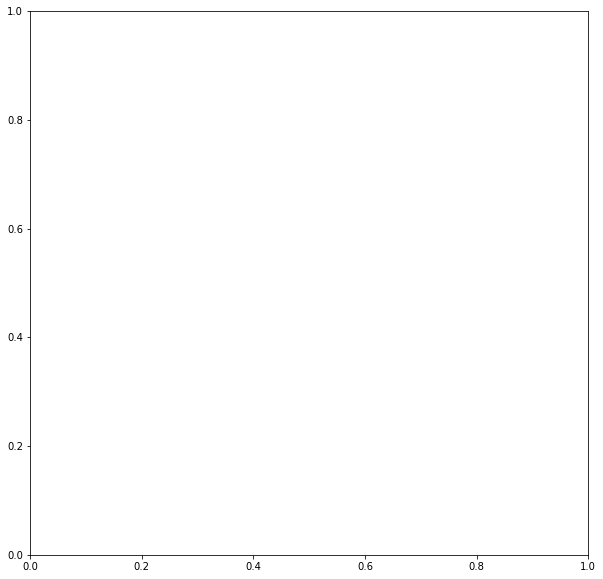

In [59]:
fig, ax = plt.subplots(figsize = (10,10));

x1data = []
x2data = []
y1data = []
y2data = []

for datapoint in presentation_plot_index:
    

    mu1 = [qoi_pred.iloc[datapoint]['CMR_fine'], qoi_pred.iloc[datapoint]['CMR_coarse']]
    sigma1 = [qoi_pred.iloc[datapoint]['GSD_fine'], qoi_pred.iloc[datapoint]['GSD_coarse']]
    mu2 = [qoi_test.iloc[datapoint]['CMR_fine'], qoi_test.iloc[datapoint]['CMR_coarse']]
    sigma2 = [qoi_test.iloc[datapoint]['GSD_fine'], qoi_test.iloc[datapoint]['GSD_coarse']]
    Vtot1 = qoi_pred.iloc[datapoint]['V_tot']
    Vtot2 = qoi_test.iloc[datapoint]['V_tot']
    
    x1 = np.linspace(min(bins1), max(bins1), 100000)
    x2 = np.linspace(min(bins2), max(bins2), 100000)
    
    pdf1 = [(Vtot1 / (np.sqrt(2 * np.pi) * np.log(sigma1[0]))) * np.exp((-np.square((np.log(x) - np.log(mu1[0])))) / (2 * np.square(np.log(sigma1[0])))) +
             (Vtot1 / (np.sqrt(2 * np.pi) * np.log(sigma1[1]))) * np.exp((-np.square((np.log(x) - np.log(mu1[1])))) / (2 * np.square(np.log(sigma1[1])))) for x in x1]
    
            
    pdf2 = [(Vtot2 / (np.sqrt(2 * np.pi) * np.log(sigma2[0]))) * np.exp((-np.square((np.log(x) - np.log(mu2[0])))) / (2 * np.square(np.log(sigma2[0])))) +
             (Vtot2 / (np.sqrt(2 * np.pi) * np.log(sigma2[1]))) * np.exp((-np.square((np.log(x) - np.log(mu2[1])))) / (2 * np.square(np.log(sigma2[1])))) for x in x2]
    

    
    x1data.append(x1)
    x2data.append(x2)
    y1data.append(pdf1)
    y2data.append(pdf2)


In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for datalen in (0,1,2,3):
    print(presentation_plot_index[datalen])
     
    if datalen == 0:        
        ax.plot(x1data[datalen], y1data[datalen],'b', linewidth=2,label ='Retrieved test data', zorder = 5)
        ax.plot(x2data[datalen], y2data[datalen], '*g',linewidth=1, label = 'Simulated test data', zorder = 0)
    else:
        ax.plot(x1data[datalen], y1data[datalen],'b', linewidth=2 , zorder = 5)#,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen], '*g',linewidth=1, zorder = 0)#, label = 'Simulated test data')
        
    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')

In [60]:
wl = ['450', '532','630']
wl_P11_450 = []
wl_P11_532 = []
wl_P11_630 = []
wl_P12_450 = []
wl_P12_532 = []
wl_P12_630 = []
for key in qoi_columns:
    if 'P11_0.450' in key:
        wl_P11_450.append(key)
    elif 'P11_0.532' in key:
        wl_P11_532.append(key)
    elif 'P11_0.630' in key:
        wl_P11_630.append(key)
    elif 'P12_0.450' in key:
        wl_P12_450.append(key)
    elif 'P12_0.532' in key:
        wl_P12_532.append(key)
    elif 'P12_0.630' in key:
        wl_P12_630.append(key)

In [61]:
wl_list_P11 = [wl_P11_450,wl_P11_532,wl_P11_630]

In [62]:
wl_list_P12 = [wl_P12_450, wl_P12_532, wl_P12_630]

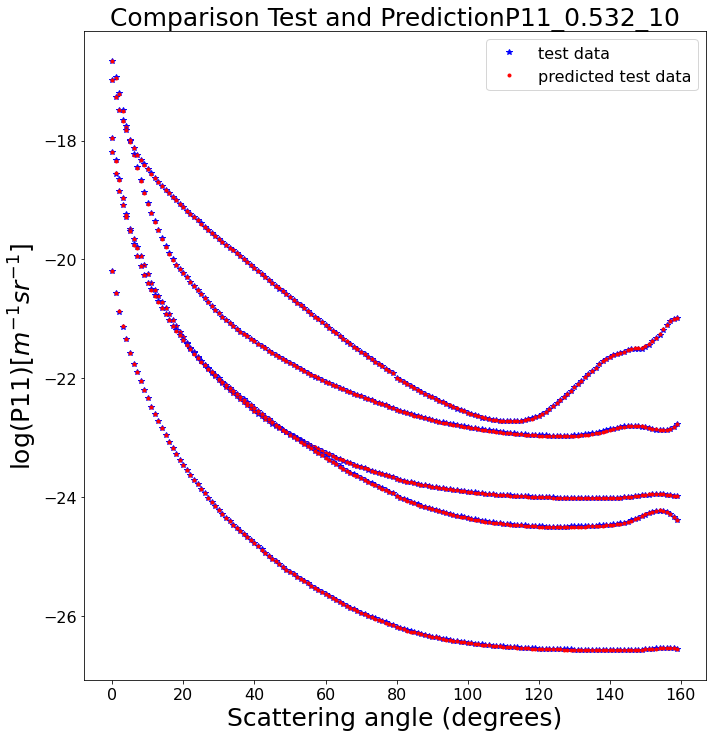

In [63]:
for wl_item in wl_list_P11:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred[wl_item].iloc[index],'r.')

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('log(P11)[$m^{-1}sr^{-1}$]',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

In [64]:
for wl_item in wl_list_P12:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred[wl_item].iloc[index],'r.')
    
    

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('P11\P12',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

## correlation plots

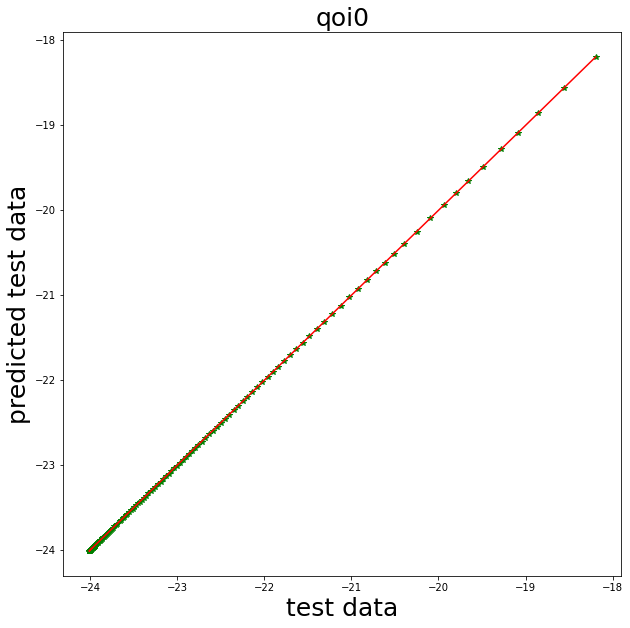

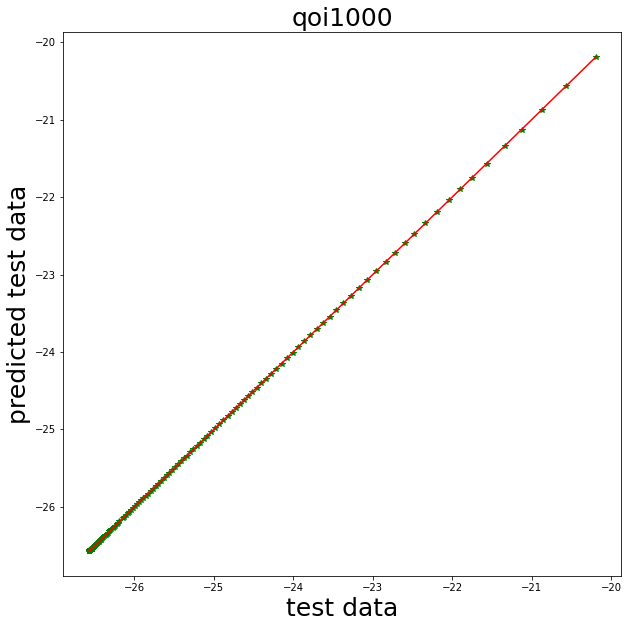

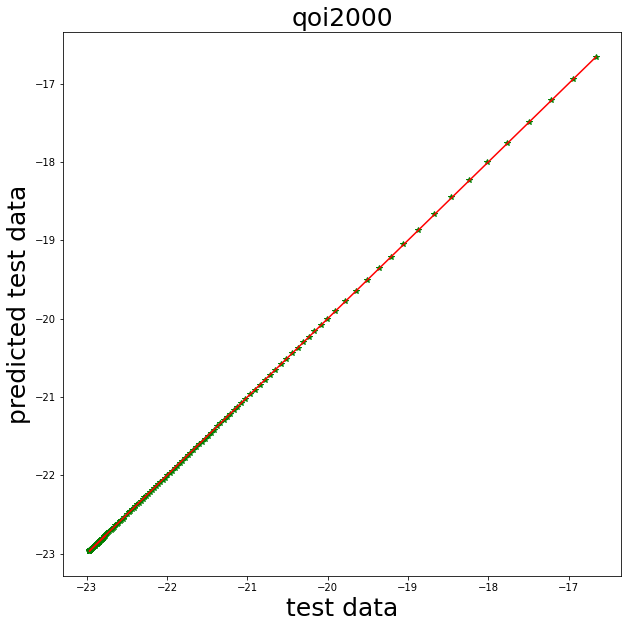

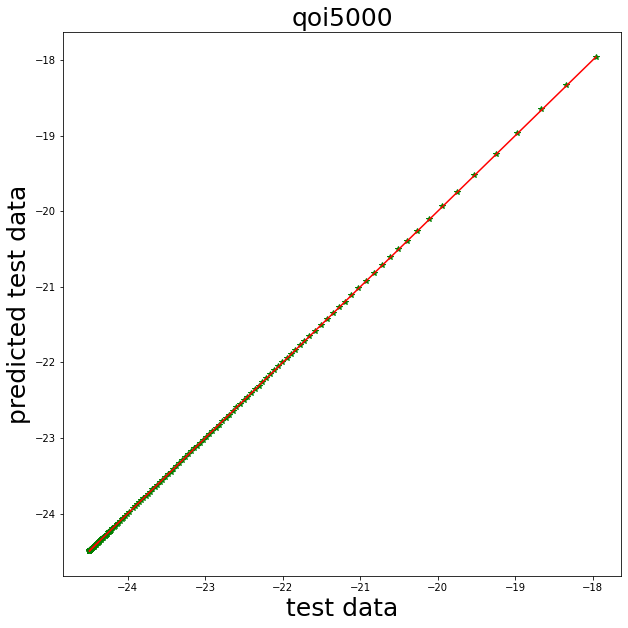

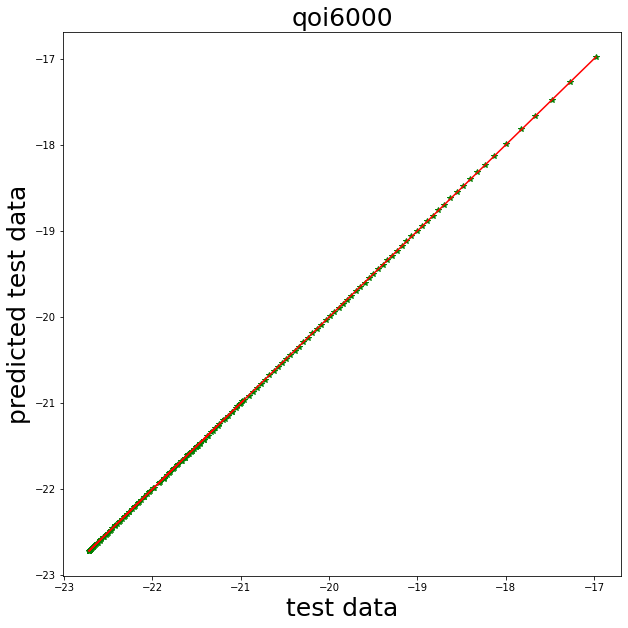

In [65]:
for index in presentation_plot_index:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(qoi_pred.iloc[index],qoi_test.iloc[index],'g*')
    ax.plot(qoi_test.iloc[index],qoi_test.iloc[index],'r')
    ax.set_title('qoi'+str(index), fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

## Plot R2 

In [66]:
r2_adj

NameError: name 'r2_adj' is not defined

NameError: name 'r2_adj' is not defined

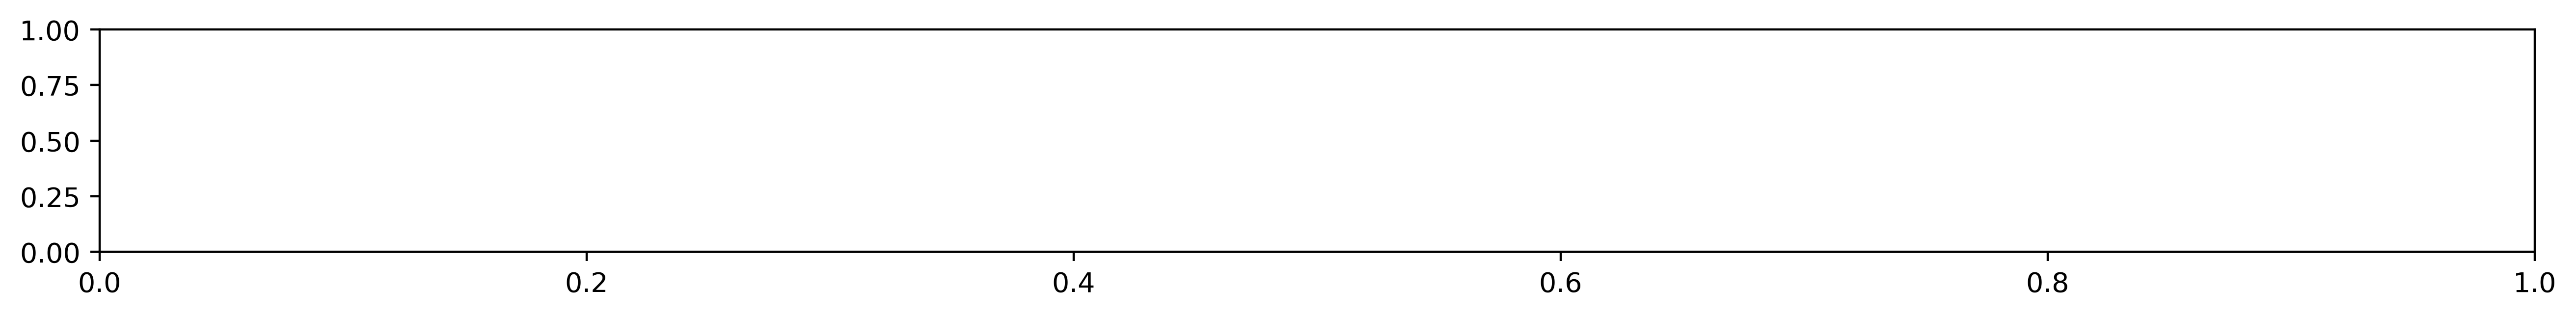

In [67]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()
ax.set_ylabel('r2_adj')
# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_model_r2_adj.jpg')


## Plot Relative / Absolute Errors 

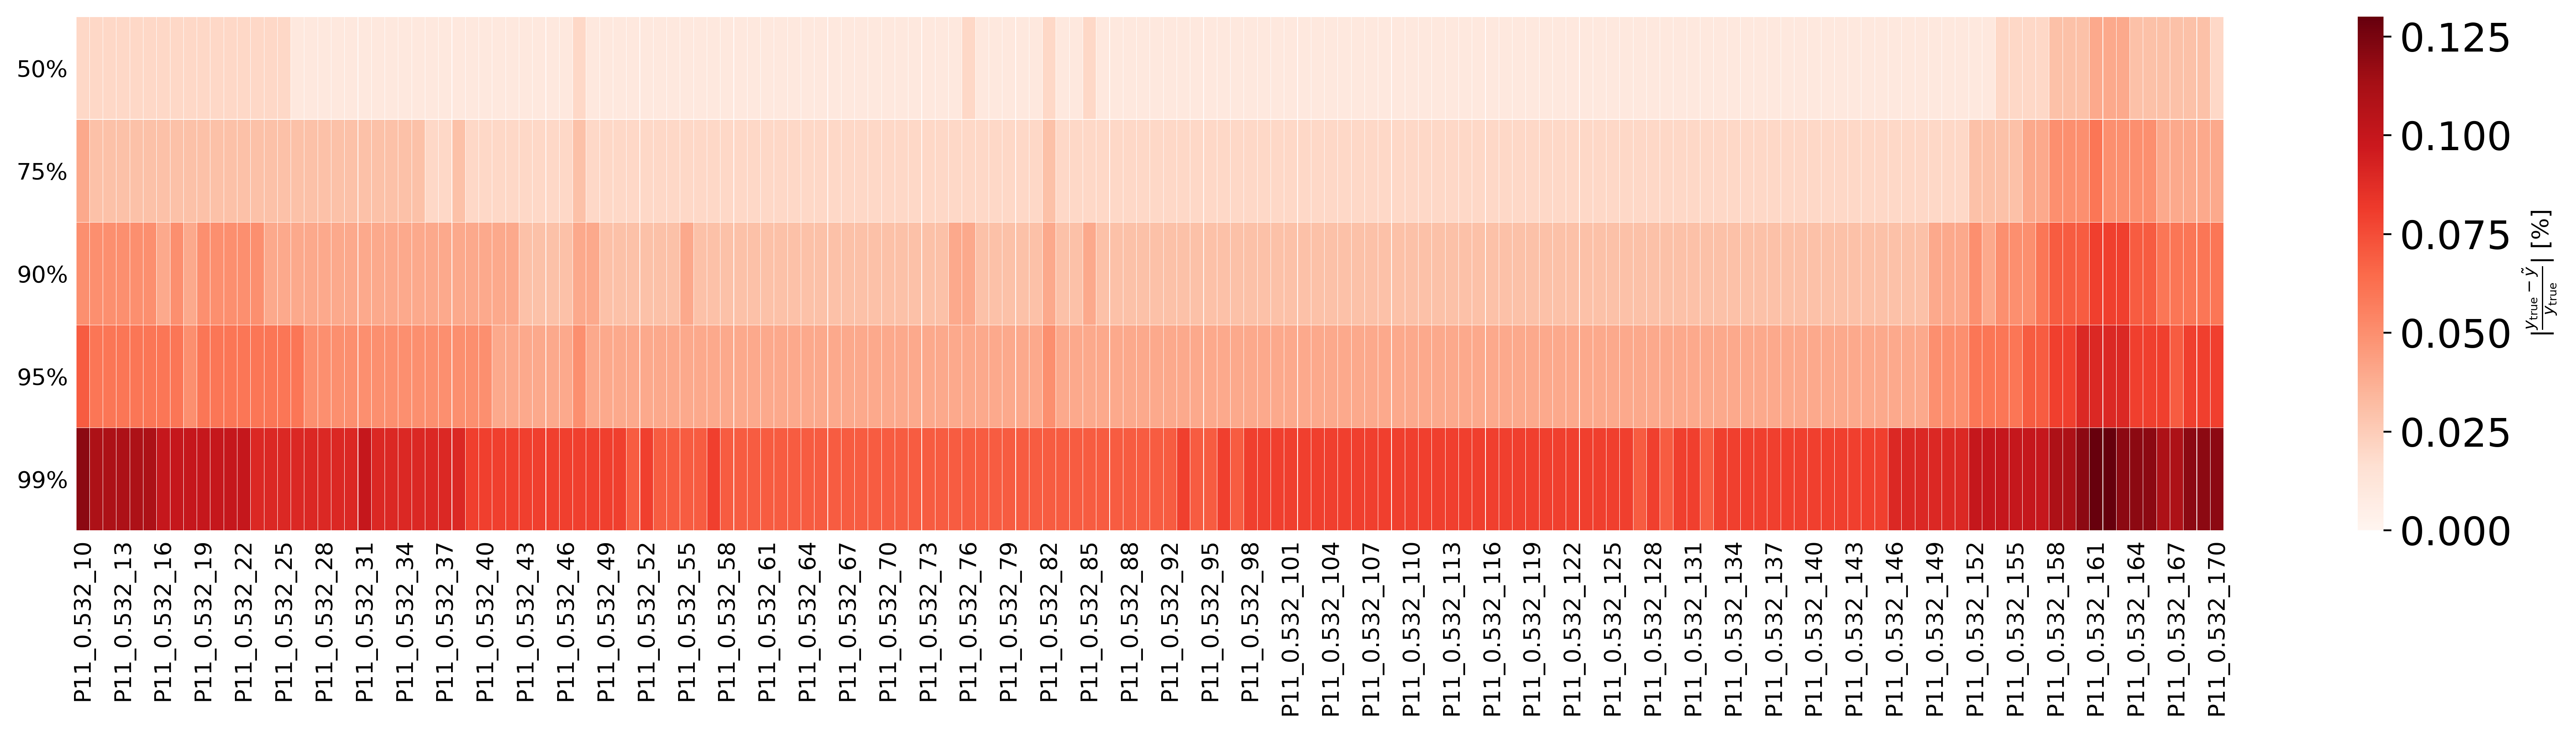

In [68]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_P11,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles_P11.jpg')

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/matrix.py:301: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


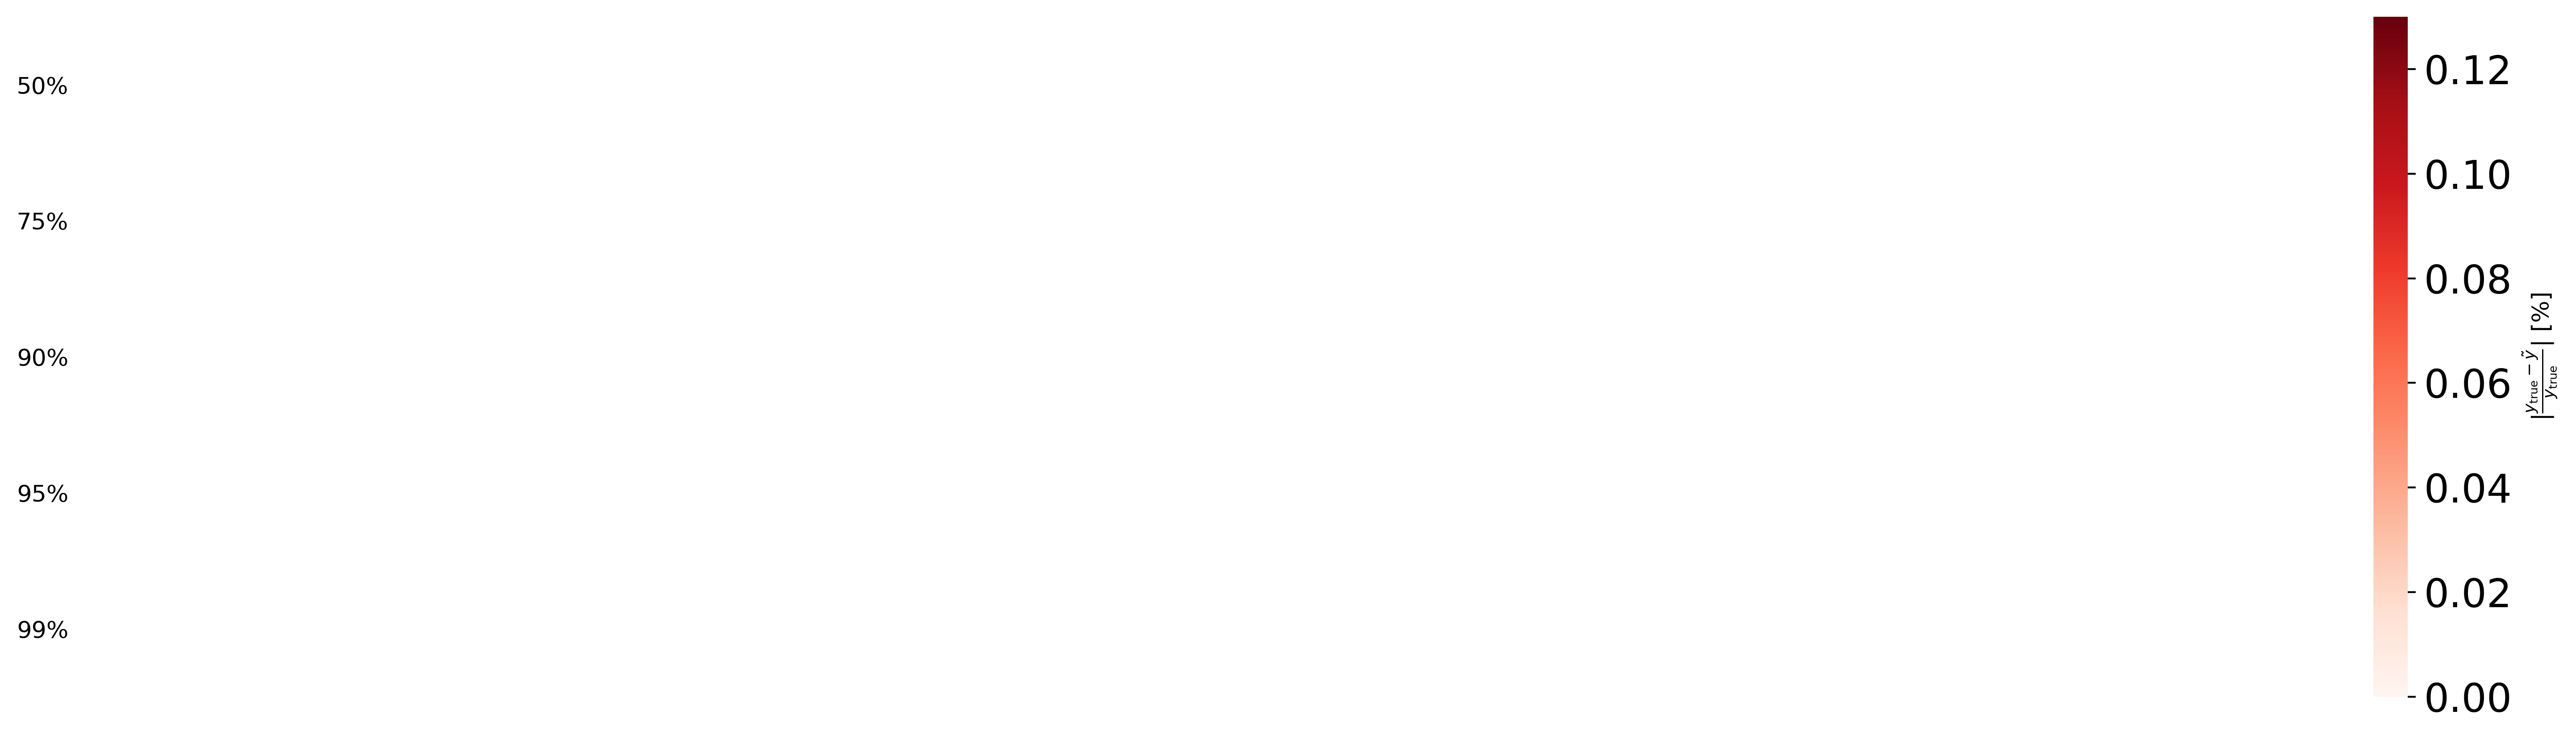

In [69]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(abs_error_table_P12,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles_P12.jpg')

# Further plots
## DVARs vs. percentage errors

In [70]:
def plot_error_vs_dvar(design_var):
    fig, axes = plt.subplots(4, 3, figsize=(16, 27))


    for i, col in enumerate(qoi_test.columns[0:12]):
        ax = axes.flatten()[i]

        ax.plot(dvar_test[design_var],
                rel_error[col],
                'o');

        ax.hlines(y=0.,
                  xmin=dvar_test[design_var].min(),
                  xmax=dvar_test[design_var].max(),
                  color='red',
                  zorder=3)

        ax.set_xlabel(design_var, fontsize=20)
        ax.set_ylabel(r'$\Delta$' + col + r' [%]', fontsize=20)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        

    fig.tight_layout()
    fig.savefig(f'{plot_dir}/percentage_error_vs_{design_var}.jpg')
    
    return fig

In [71]:
qoi_test.columns[0:11]

Index(['P11_0.532_10', 'P11_0.532_11', 'P11_0.532_12', 'P11_0.532_13',
       'P11_0.532_14', 'P11_0.532_15', 'P11_0.532_16', 'P11_0.532_17',
       'P11_0.532_18', 'P11_0.532_19', 'P11_0.532_20'],
      dtype='object')

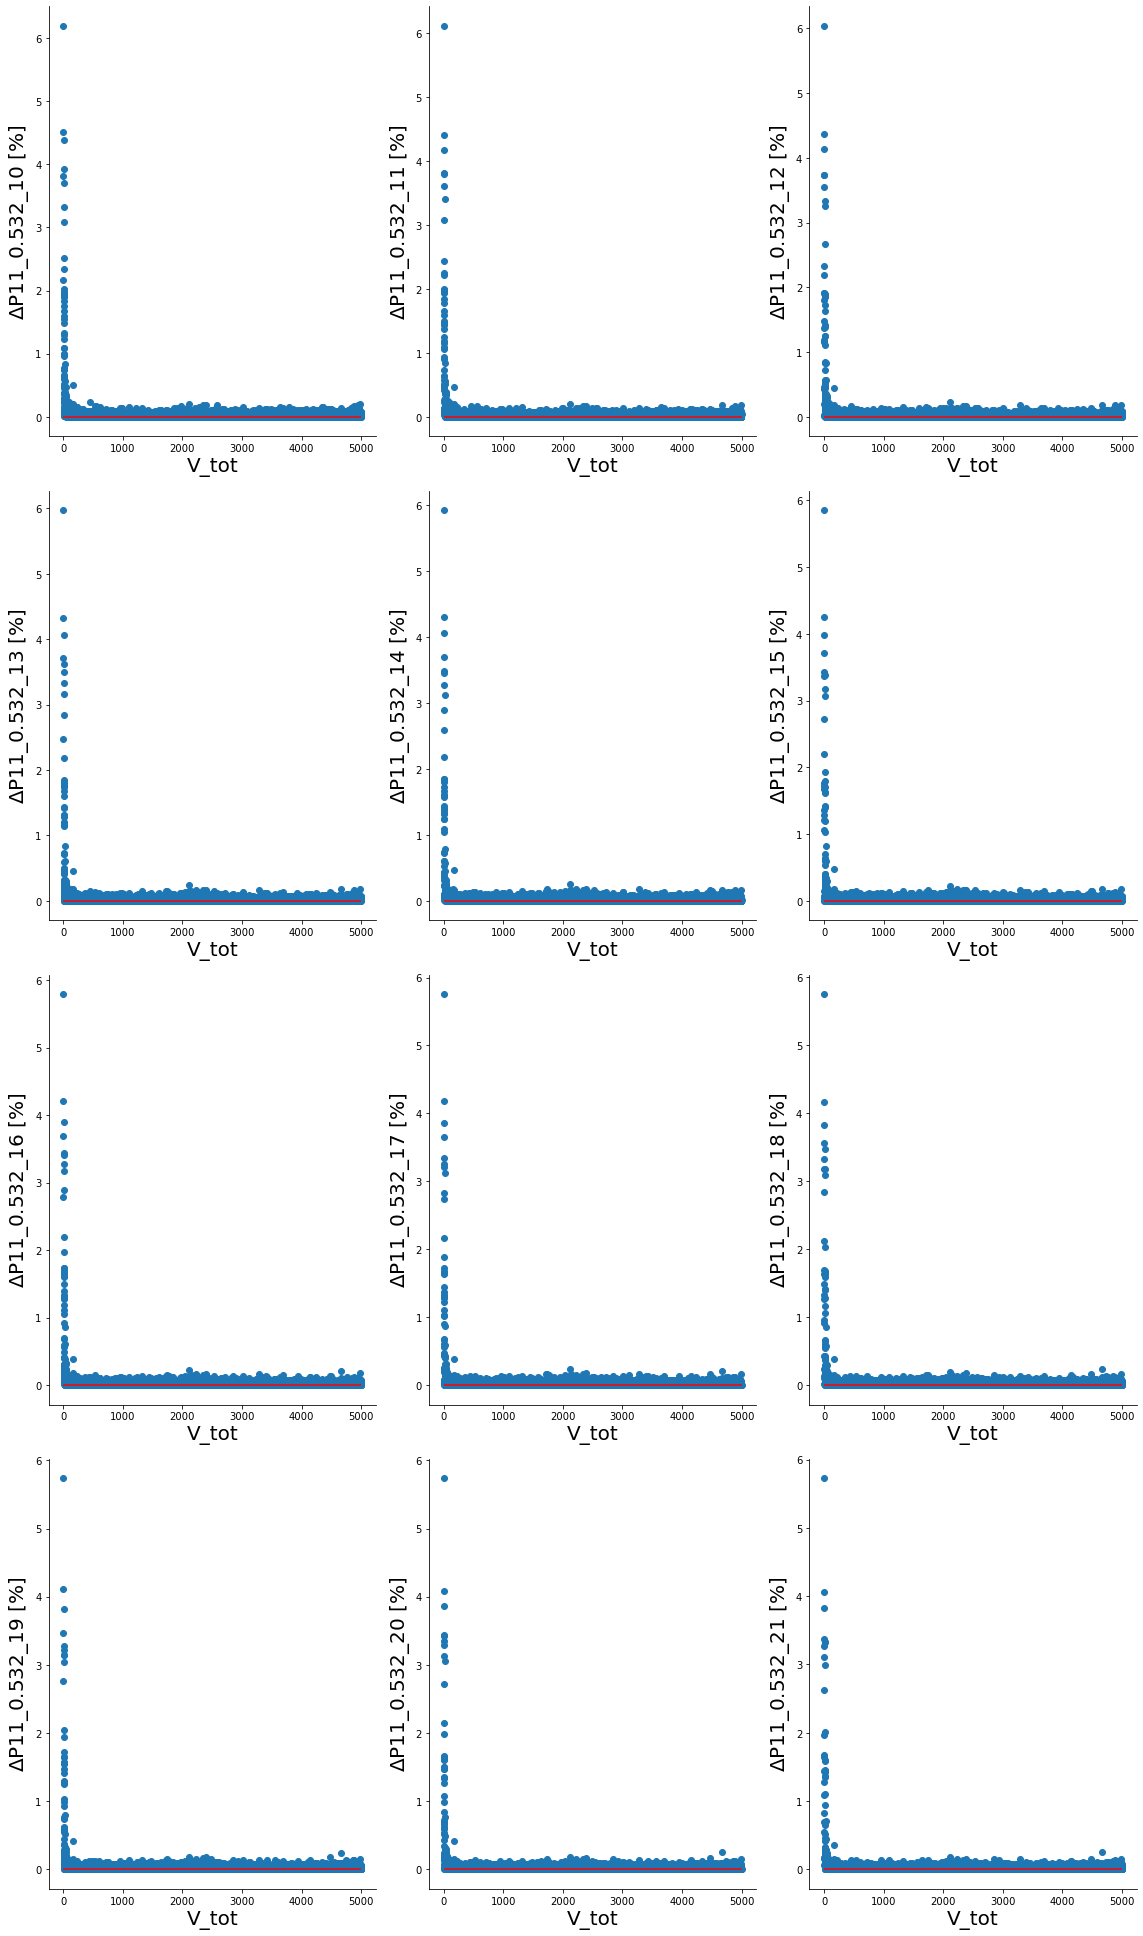

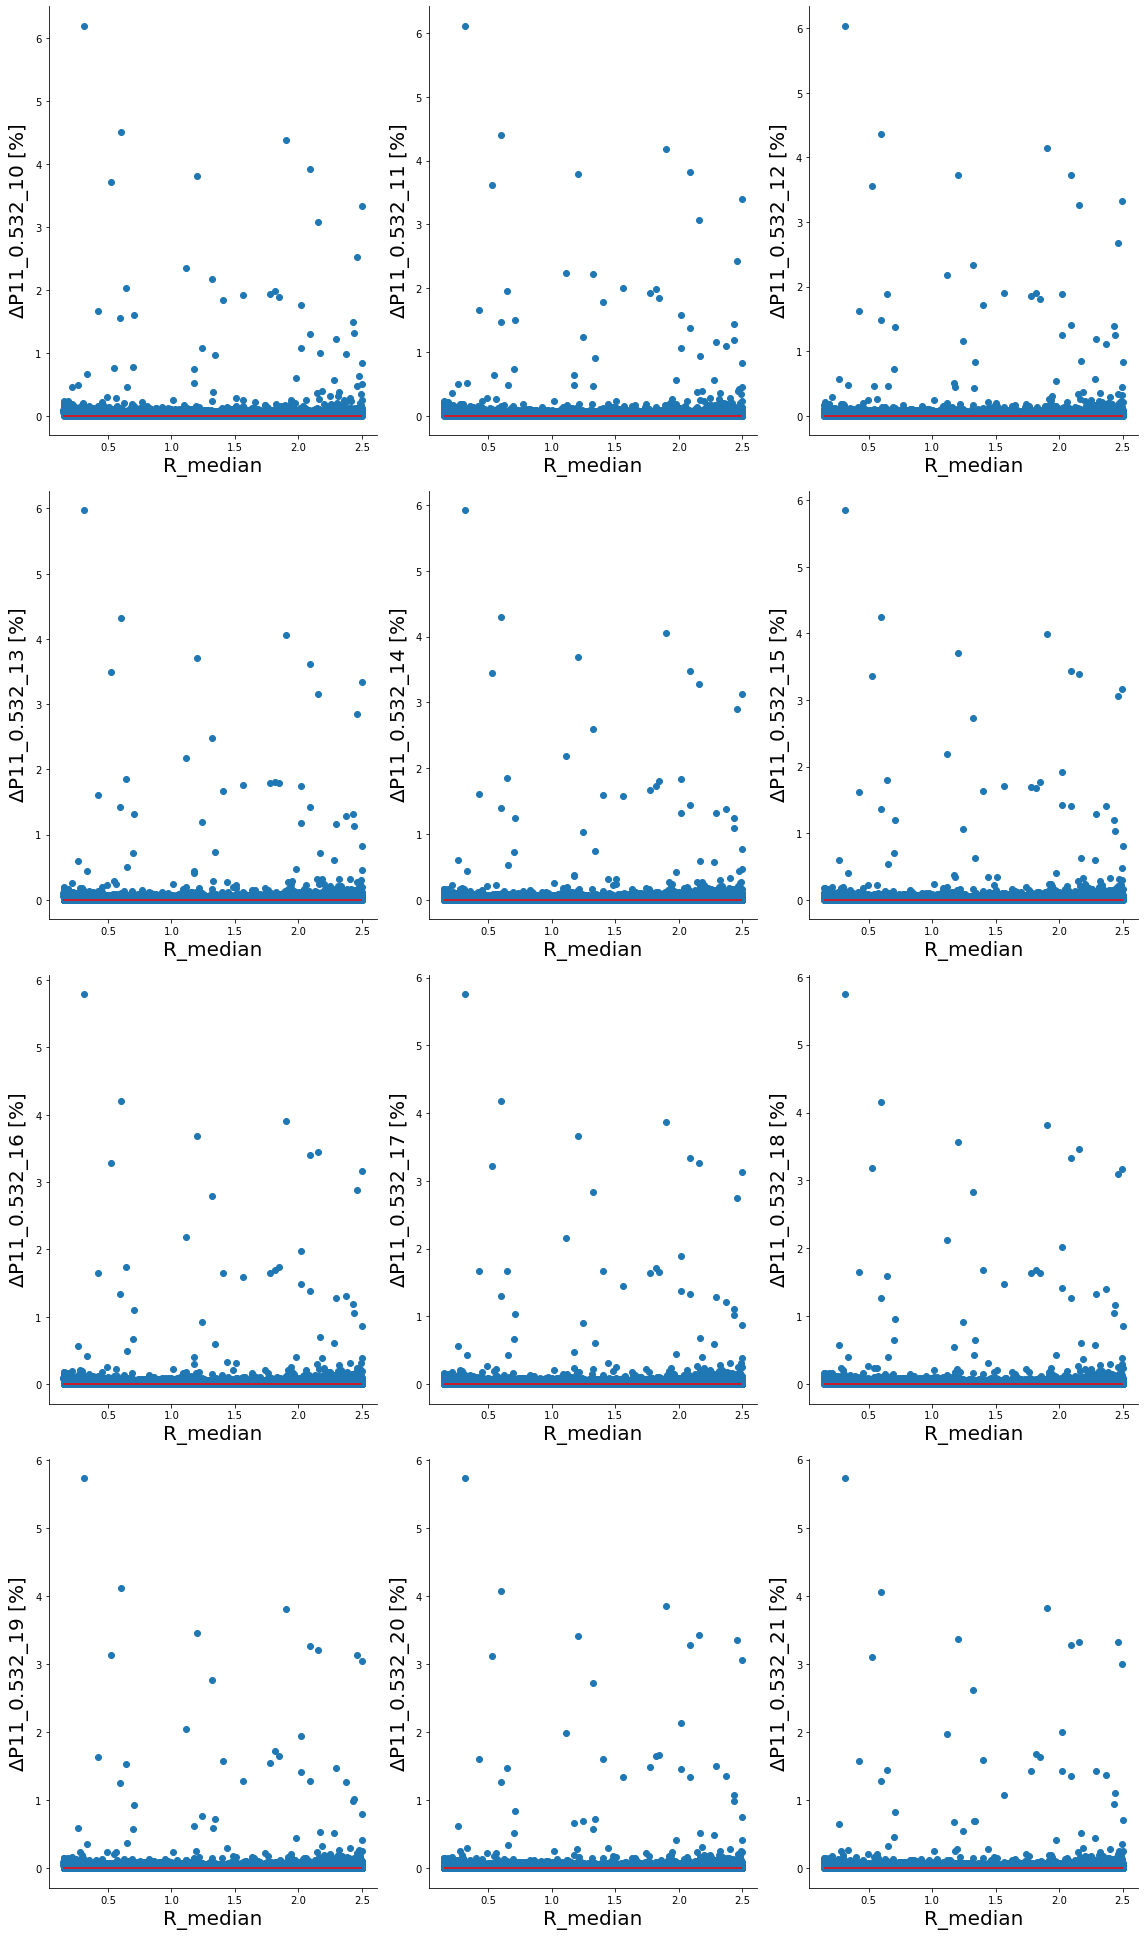

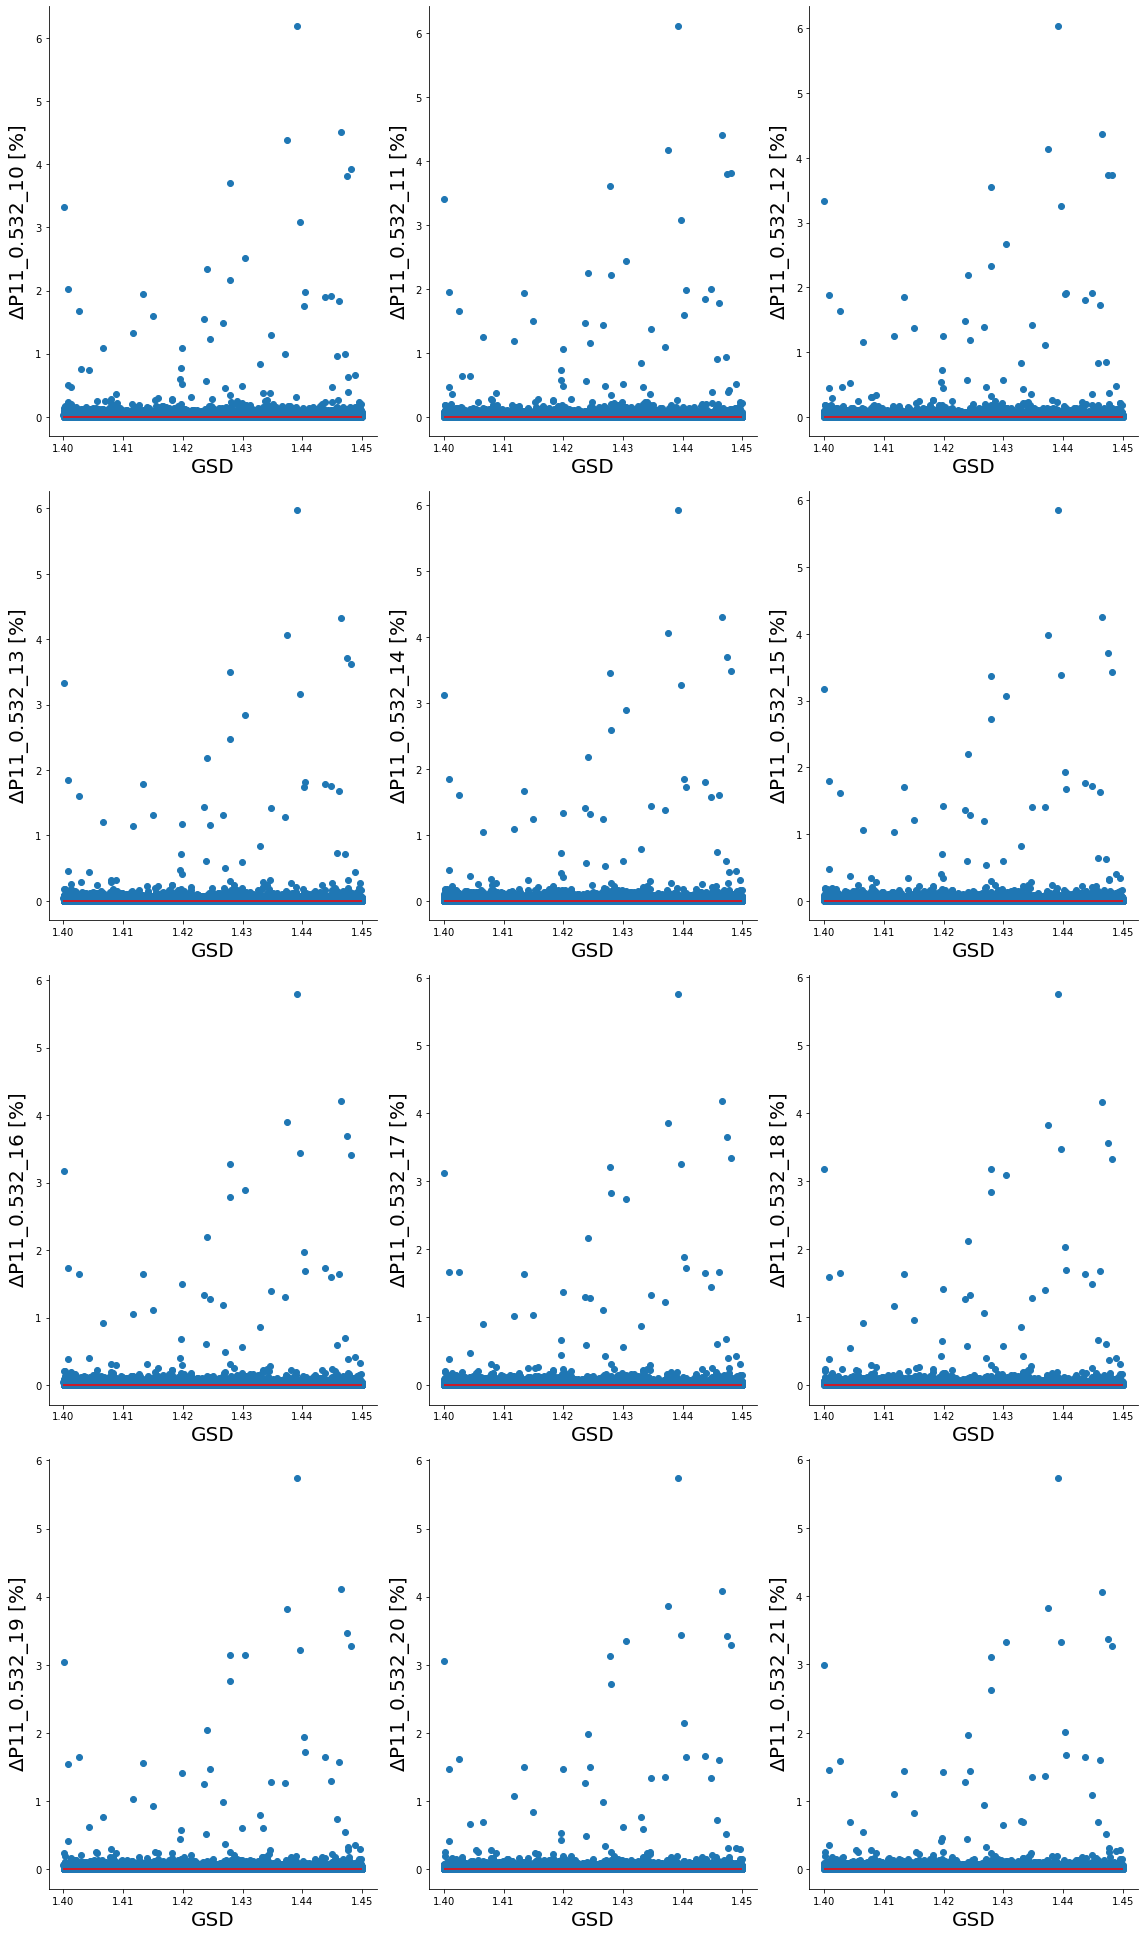

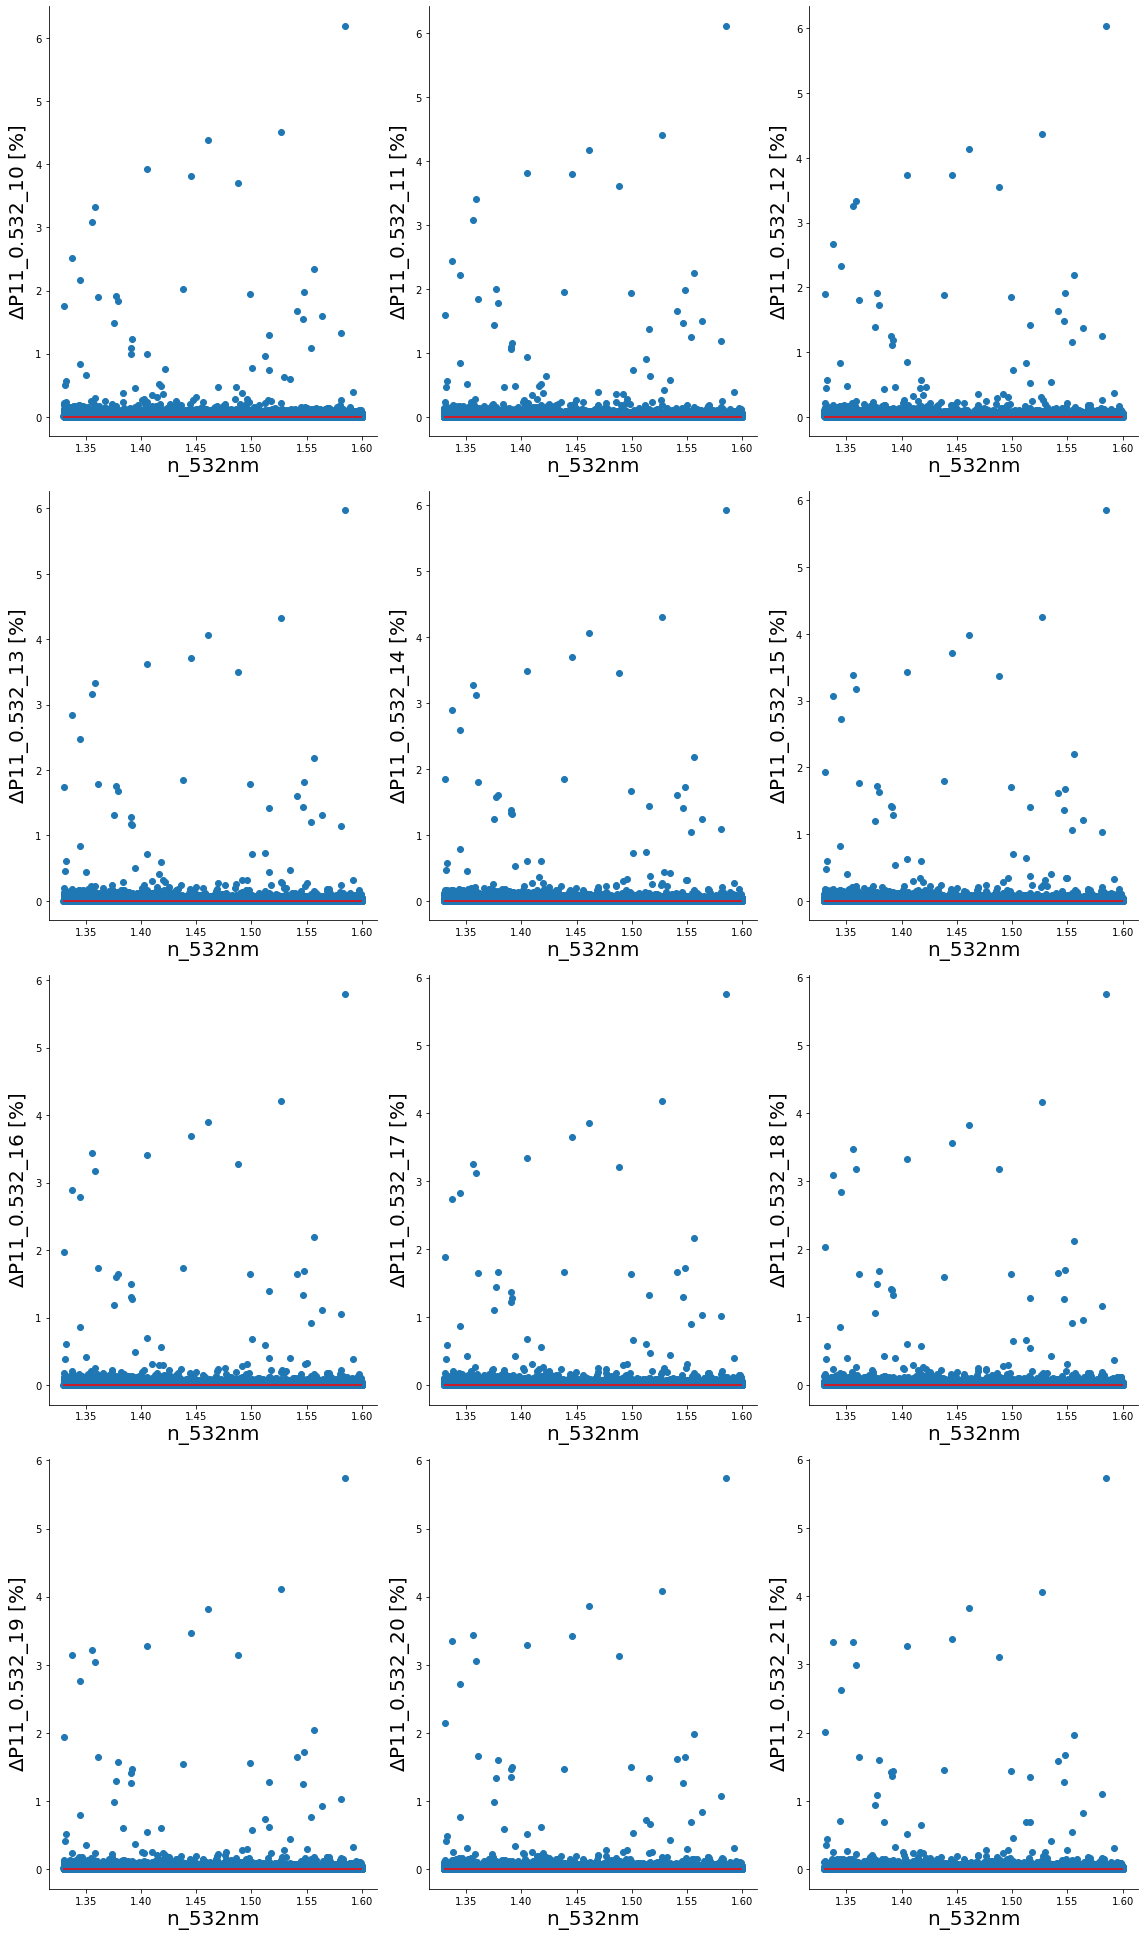

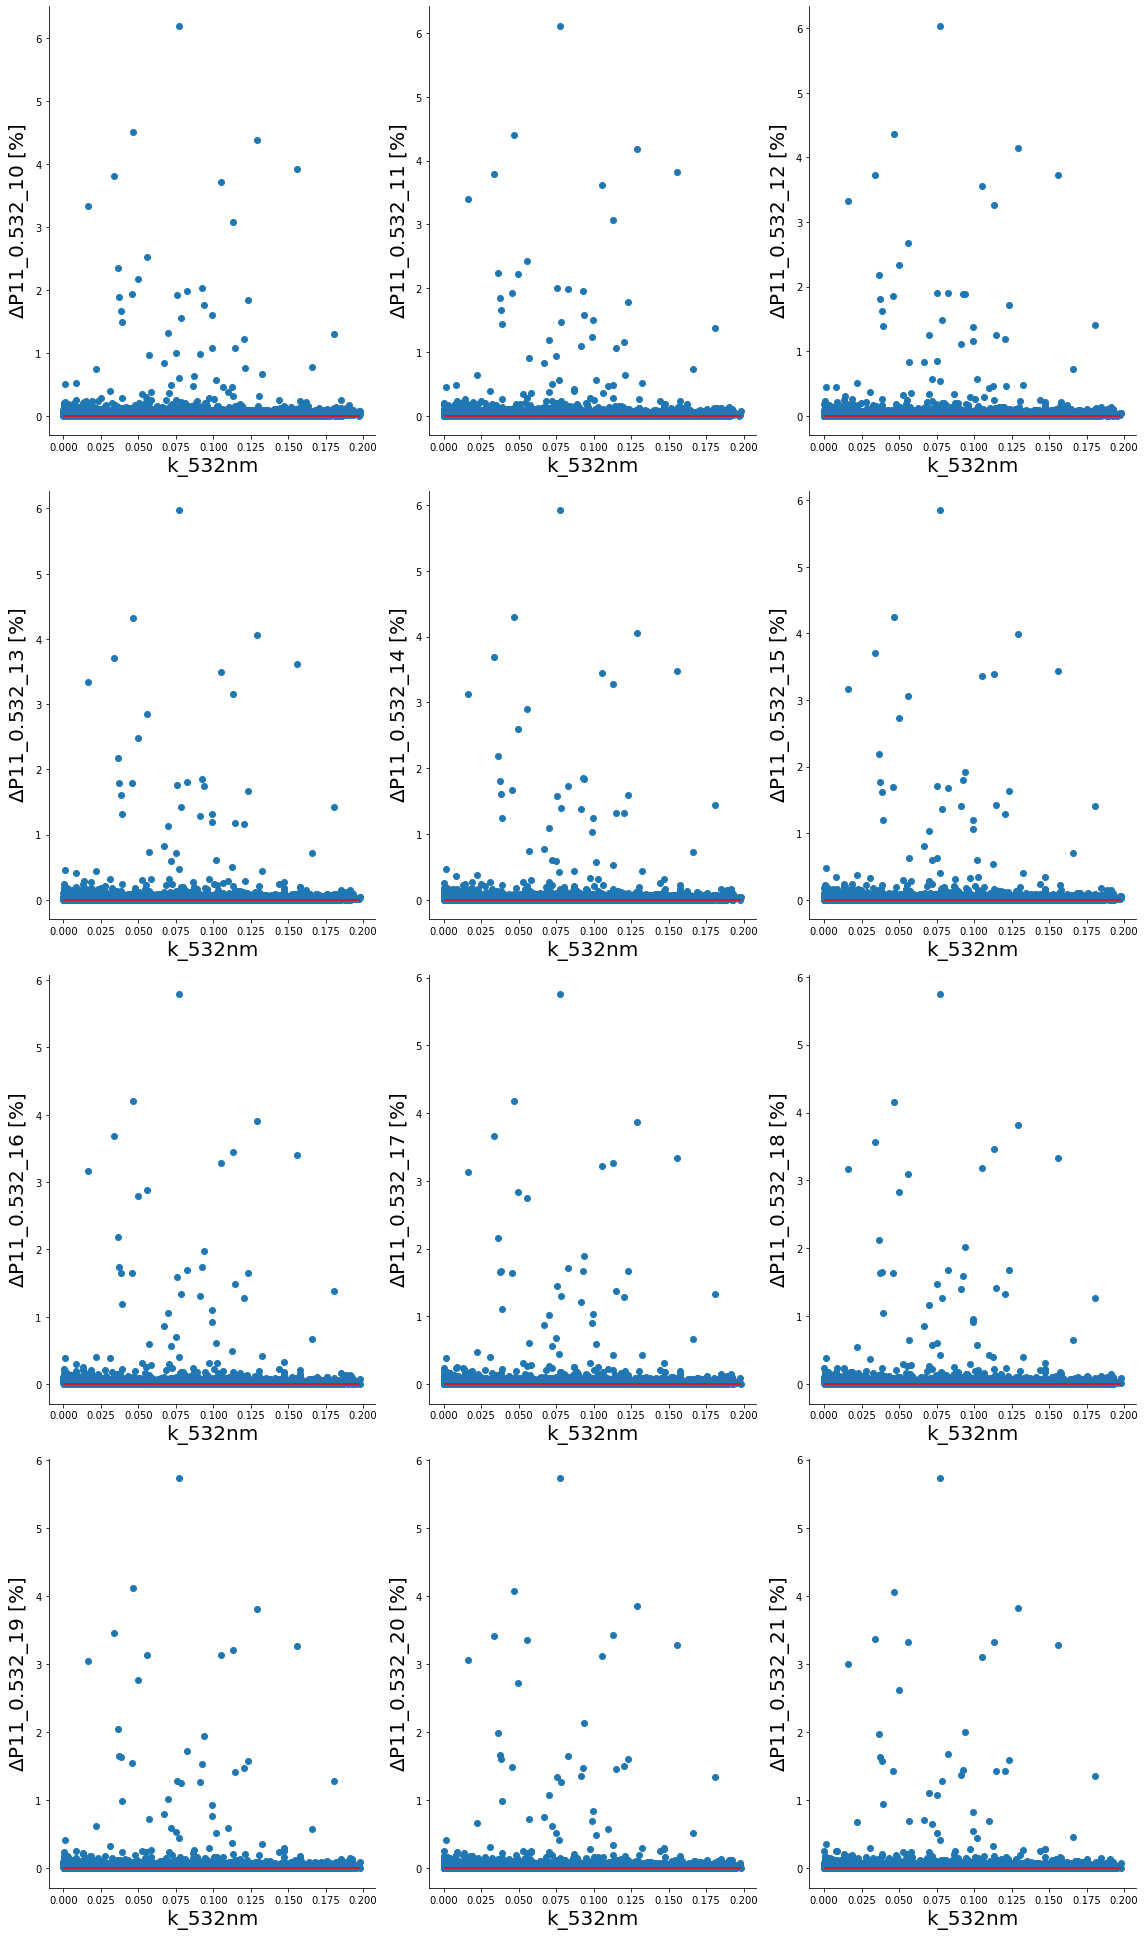

In [72]:
for d in dvar_test.columns:
    plot_error_vs_dvar(d)

## Correlations between DVARs and QOIs

In [73]:
combined = pd.concat([dvar_test, rel_error], axis=1)

In [74]:
corr = np.round(combined.corr(), decimals=2)

In [75]:
to_plot = corr.copy()
to_plot.drop(columns=dvar_test.columns, inplace=True)
#to_plot.rename(columns=qoi.columns, index=qoi.columns.values, inplace=True)

In [76]:
to_plot = to_plot.drop(qoi_test.columns, axis =0)

In [77]:
to_plot

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  \
V_tot            -0.07         -0.08         -0.08         -0.08   
R_median         -0.02         -0.01         -0.02         -0.03   
GSD               0.02          0.01          0.01          0.01   
n_532nm          -0.03         -0.03         -0.03         -0.03   
k_532nm           0.02          0.02          0.02          0.01   

          P11_0.532_14  P11_0.532_15  P11_0.532_16  P11_0.532_17  \
V_tot            -0.08         -0.08         -0.08         -0.08   
R_median         -0.04         -0.03         -0.03         -0.04   
GSD               0.00          0.01          0.01          0.00   
n_532nm          -0.03         -0.03         -0.03         -0.03   
k_532nm           0.02          0.01          0.00          0.02   

          P11_0.532_18  P11_0.532_19  ...  P11_0.532_161  P11_0.532_162  \
V_tot            -0.08         -0.08  ...           0.01           0.01   
R_median         -0.03         -0.04  ...          -0.07          -0.07   
GSD               0.01          0.00  ...           0.03           0.02   
n_532nm          -0.02         -0.03  ...          -0.03          -0.04   
k_532nm           0.01          0.03  ...          -0.12          -0.12   

          P11_0.532_163  P11_0.532_164  P11_0.532_165  P11_0.532_166  \
V_tot              0.00          -0.01          -0.02          -0.03   
R_median          -0.07          -0.05          -0.04          -0.03   
GSD                0.03           0.02           0.03           0.03   
n_532nm           -0.04          -0.04          -0.03          -0.03   
k_532nm           -0.10          -0.09          -0.07          -0.05   

          P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
V_tot             -0.05          -0.04          -0.06          -0.06  
R_median          -0.03          -0.05          -0.06          -0.06  
GSD                0.03           0.03           0.02           0.01  
n_532nm           -0.01          -0.00           0.01           0.02  
k_532nm           -0.04          -0.02          -0.01          -0.02  

[5 rows x 160 columns]

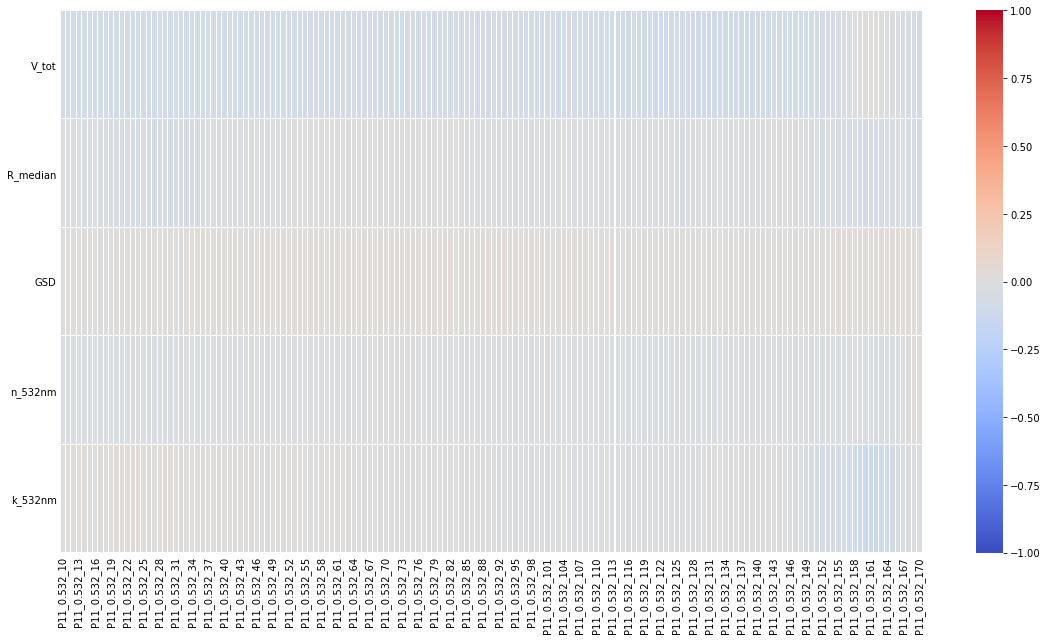

In [78]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            cmap='coolwarm',
            linewidths=0.01,
           # annot=True,
            ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', length=0, labelsize=10)

fig.tight_layout()
fig.savefig(f'{plot_dir}/rel_error_correlations.jpg')

## Residuals

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

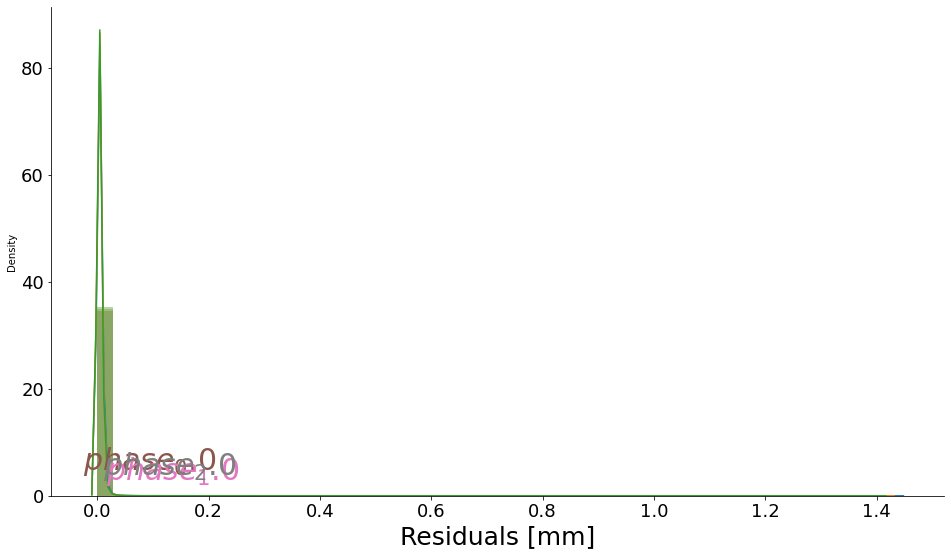

In [79]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi_test.columns[0:3]:
    sns.distplot(abs_error[col], ax=ax)
ax.text(x=-0.025,
        y=5,
        color=colors[5],
        s=r'$phase_0.0$',
        fontsize=30)
ax.text(x=0.015,
        y=3,
        color=colors[6],
        s=r'$phase_1.0$',
        fontsize=30)
ax.text(x=0.01,
        y=4,
        color=colors[7],
        s=r'$phase_2.0$',
        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi.columns:
    sns.distplot(error[col], ax=ax)
#ax.text(x=-0.025,
#        y=15,
#        color=colors[0],
#        s=r'$\sigma_x$',
#        fontsize=30)
#ax.text(x=0.015,
#        y=30,
#        color=colors[1],
#        s=r'$\sigma_y$',
#        fontsize=30)
#ax.text(x=0.01,
#        y=40,
#        color=colors[2],
#        s=r'$\sigma_z$',
#        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

In [80]:
def standardise(x):
    return (x - x.mean()) / x.std()

In [81]:
for i, col in enumerate(qoi_test.columns[0:11]):
    print(i)
    print(col)

0
P11_0.532_10
1
P11_0.532_11
2
P11_0.532_12
3
P11_0.532_13
4
P11_0.532_14
5
P11_0.532_15
6
P11_0.532_16
7
P11_0.532_17
8
P11_0.532_18
9
P11_0.532_19
10
P11_0.532_20


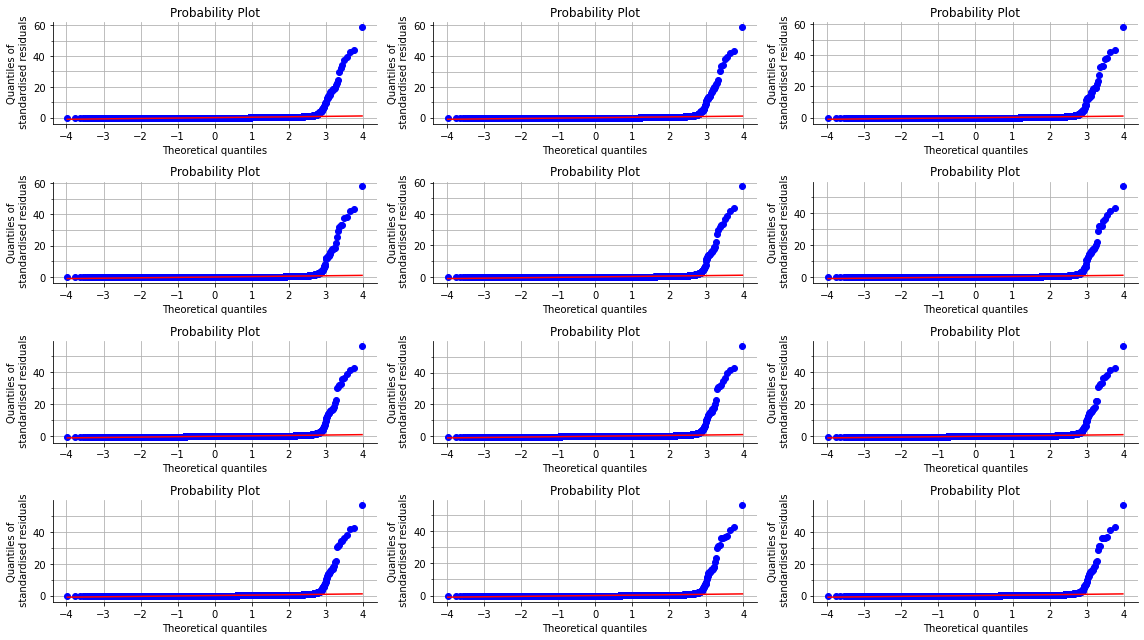

In [82]:
fig, axes= plt.subplots(4, 3, figsize=(16, 9))

for i, col in enumerate(qoi_test.columns[0:12]):
    ax = axes.flatten()[i]
    scipy.stats.probplot(standardise(abs_error[col]), dist="norm", plot=ax);
#    ax.set_title(qoi.columns[col], fontsize=20)
    ax.set_ylabel('Quantiles of\n standardised residuals')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.grid(True, which='minor')
    #ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

fig.tight_layout()
fig.savefig(f'{plot_dir}/residual_normality_plots.jpg')

In [83]:
# pd.DataFrame({'Mean': error.mean(axis=0), 'std': error.std(axis=0)})

In [84]:
statistic, p = scipy.stats.shapiro(standardise(abs_error[qoi_test.columns[0]]).values)

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [85]:
statistic

0.07416397333145142

In [86]:
p

0.0

In [87]:
surr.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 147)               882       
_________________________________________________________________
dense_1 (Dense)              (None, 147)               21756     
_________________________________________________________________
dense_2 (Dense)              (None, 147)               21756     
_________________________________________________________________
dense_3 (Dense)              (None, 147)               21756     
_________________________________________________________________
dense_4 (Dense)              (None, 147)               21756     
_________________________________________________________________
dense_5 (Dense)              (None, 147)               2

In [88]:
from keras.utils.vis_utils import plot_model

ModuleNotFoundError: No module named 'keras'

In [ ]:
plot_dir

In [ ]:
plot_model(surr.model, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


In [ ]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            linewidths = 0.01,
            cmap='coolwarm',)
plt.tick_params(labelsize = 16)
plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_forward_model.jpg')


# Store results

In [ ]:
configs = pd.read_csv(f'{model_dir}/configs.csv')
configs.columns

In [ ]:
store_results = pd.DataFrame()

In [ ]:
if 'P11' in qoi_columns[0]:
    store_results['rel_error95%_qoi_P11_max'] = rel_error_table_P11.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P11_max'] = abs_error_table_P11.max(axis = 1)['95%']
else:
    store_results['rel_error95%_qoi_P11_max'] = 0
    store_results['abs_error95%_qoi_P11_max'] = 0
if 'P12' in qoi_columns[-1]:
    store_results['rel_error95%_qoi_P12_max'] = rel_error_table_P12.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P12_max'] = abs_error_table_P12.max(axis = 1)['95%']
else:    
    store_results['rel_error95%_qoi_P12_max'] = 0
    store_results['abs_error95%_qoi_P12_max'] = 0
store_results['MAE_qoi_max'] = MAE_all_qoi.max(axis= 1).values
store_results['MAPE%_qoi_max'] = MAPE_all_qoi.max(axis= 1).values
store_results['explained_variance_qoi_min'] = EVS_all_df.min(axis = 1)





store_results['preprocessor_x'] = configs['config/preprocessor_x']
store_results['preprocessor_y'] = configs['config/preprocessor_y']

In [ ]:
store_results['data_file'] = configs['config/datafile']
store_results['batch_size'] = configs['config/batch_size']
store_results['learning_rate'] = configs['config/lr']

store_results['n_depth'] = configs['config/n_depth']
store_results['n_width'] = configs['config/n_width']

In [ ]:
store_results